In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# for compatible with python 3
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
import pandas as pd
dataset = pd.read_csv("data\stock_price_minutes.csv")

In [4]:
dataset.head()

Unnamed: 0  date_index      date    time  AAPL_open  AAPL_high  AAPL_low  \
0           0           0  20180102  173100     170.18     170.19    169.88   
1           1           1  20180102  173200     169.90     169.93    169.67   
2           2           2  20180102  173300     169.67     169.88    169.58   
3           3           3  20180102  173400     169.46     169.46    169.27   
4           4           4  20180102  173500     169.45     169.60    169.44   

   AAPL_close  AAPL_vol  BAC_open   ...     T_open  T_high  T_low  T_close  \
0      169.94     17654     29.80   ...      39.03   39.03  39.03    39.03   
1      169.69      8200     29.71   ...      39.03   39.03  38.97    39.00   
2      169.58      9380     29.77   ...      39.00   39.03  39.00    39.02   
3      169.33      5348     29.77   ...      39.02   39.02  38.97    38.97   
4      169.59      9700     29.74   ...      38.97   39.01  38.97    38.98   

   T_vol  XOM_open  XOM_high  XOM_low  XOM_close  XOM_vol  
0      0     83.82     83.84    83.77      83.77      800  
1   1000     83.80     83.94    83.80      83.94     1391  
2   5376     83.90     83.93    83.84      83.90     9400  
3   5137     83.87     83.90    83.82      83.86     8728  
4   5499     83.88     83.89    83.79      83.79     5430  

[5 rows x 79 columns]

In [5]:
df_time = pd.DataFrame({'year': dataset.date.astype(str).str.slice(0, 4).astype(int),
                        'month': dataset.date.astype(str).str.slice(4, 6).astype(int),
                        'day': dataset.date.astype(str).str.slice(6, 8).astype(int),
                        'hour': dataset.time.astype(str).str.slice(0, 2).astype(int),
                        'minute': dataset.time.astype(str).str.slice(2, 4).astype(int)
                       })

In [6]:
time_ref = pd.to_datetime(df_time)
time_ref = time_ref.to_frame()
time_ref.columns = ['Time']

In [7]:
time_ref.head()

Time
0 2018-01-02 17:31:00
1 2018-01-02 17:32:00
2 2018-01-02 17:33:00
3 2018-01-02 17:34:00
4 2018-01-02 17:35:00

In [8]:
dataset = dataset.merge(time_ref, left_index=True, right_index=True, how='left')

In [9]:
abbreviation = pd.read_csv("data\symbols.txt")

In [10]:
abbreviation

symbols
0     AAPL
1      BAC
2       BA
3       GE
4     GOOG
5      JNJ
6       KO
7       MA
8      MRK
9     MSFT
10    NVDA
11     PFE
12    SBUX
13       T
14     XOM

In [11]:
history = np.empty((15,len(dataset),5))

In [12]:
suffix = ["_open", "_close", "_high", "_low", "_vol"]

In [13]:
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history[i_n, :, j_n] = dataset[i+j]

In [14]:
history.shape

(15, 81101, 5)

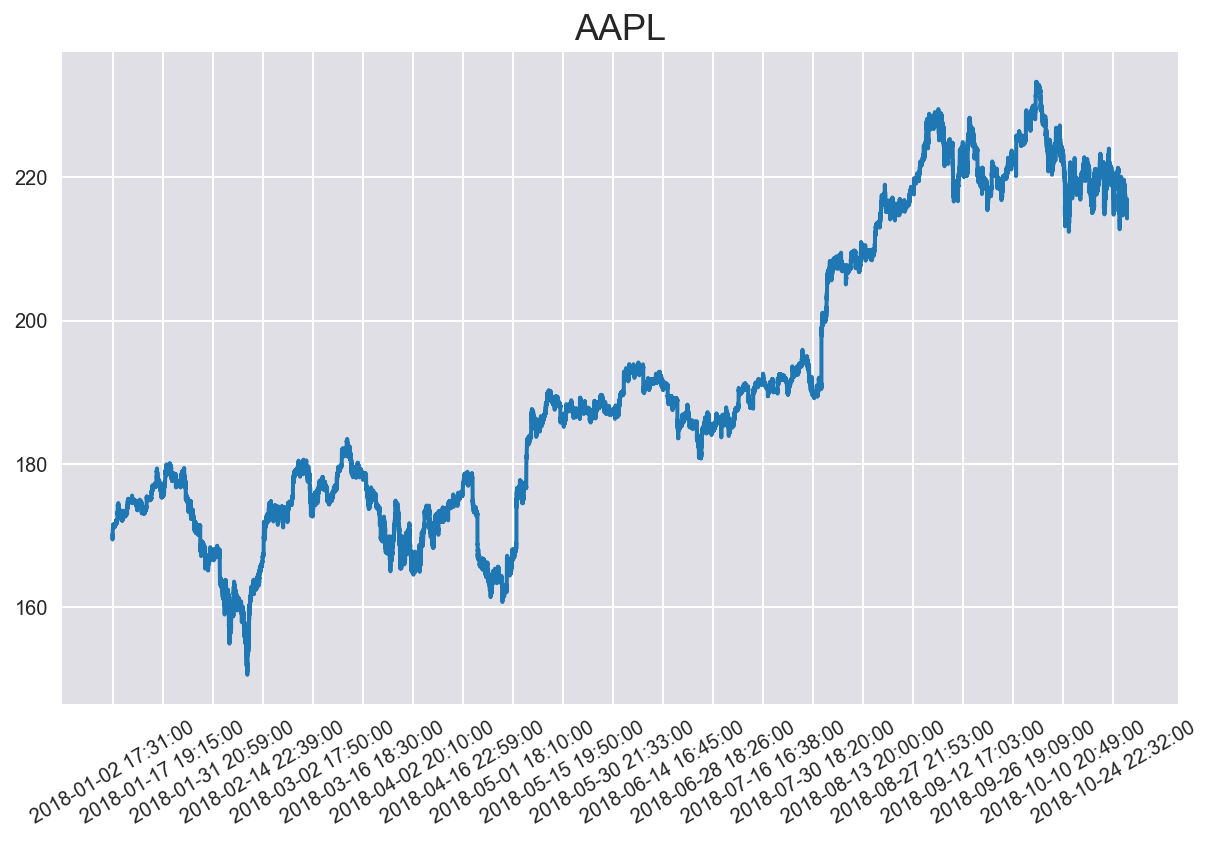

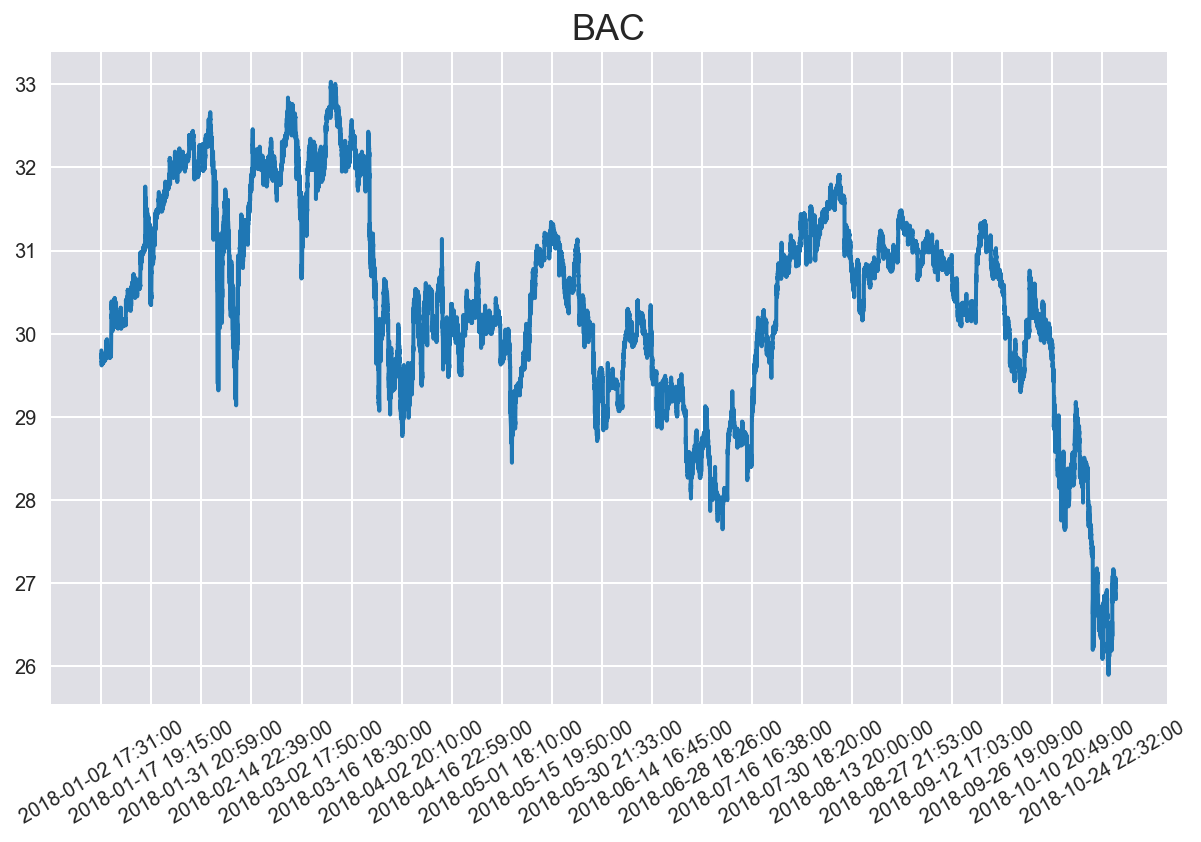

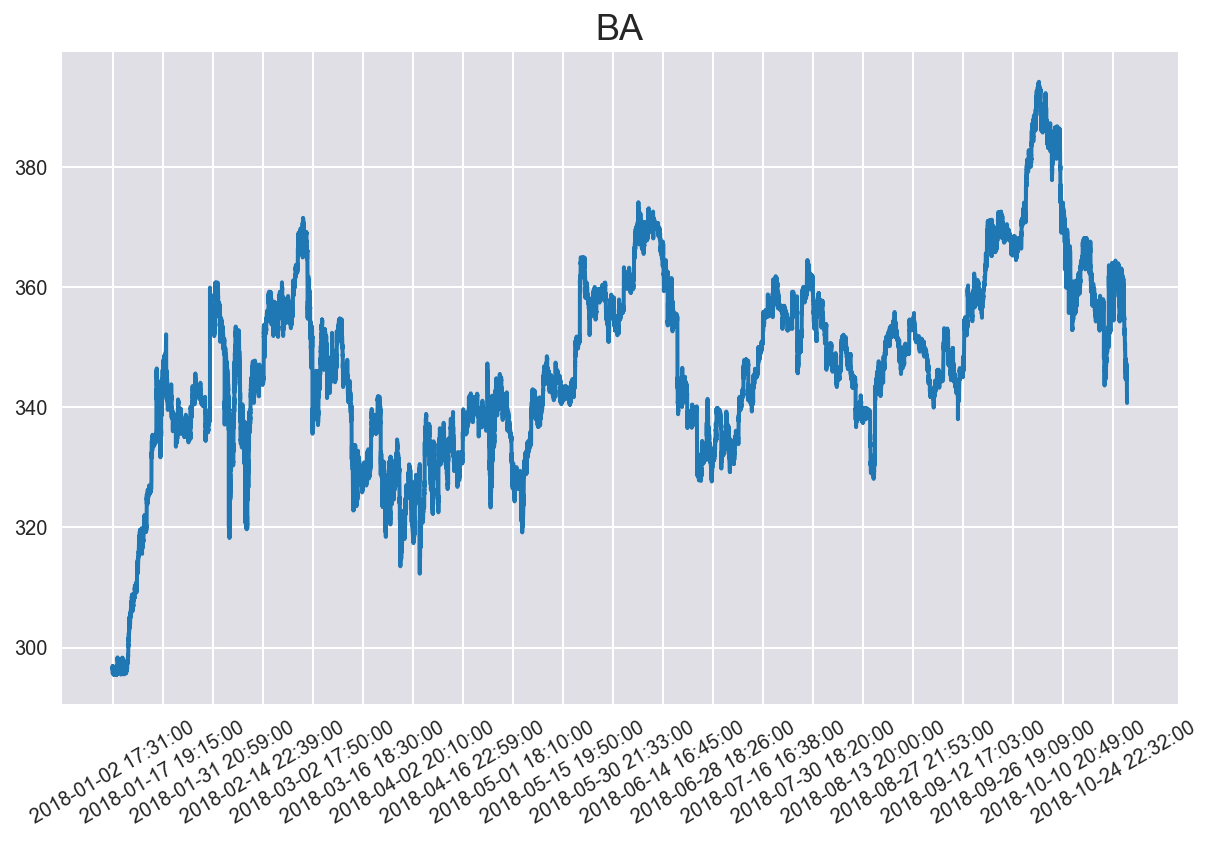

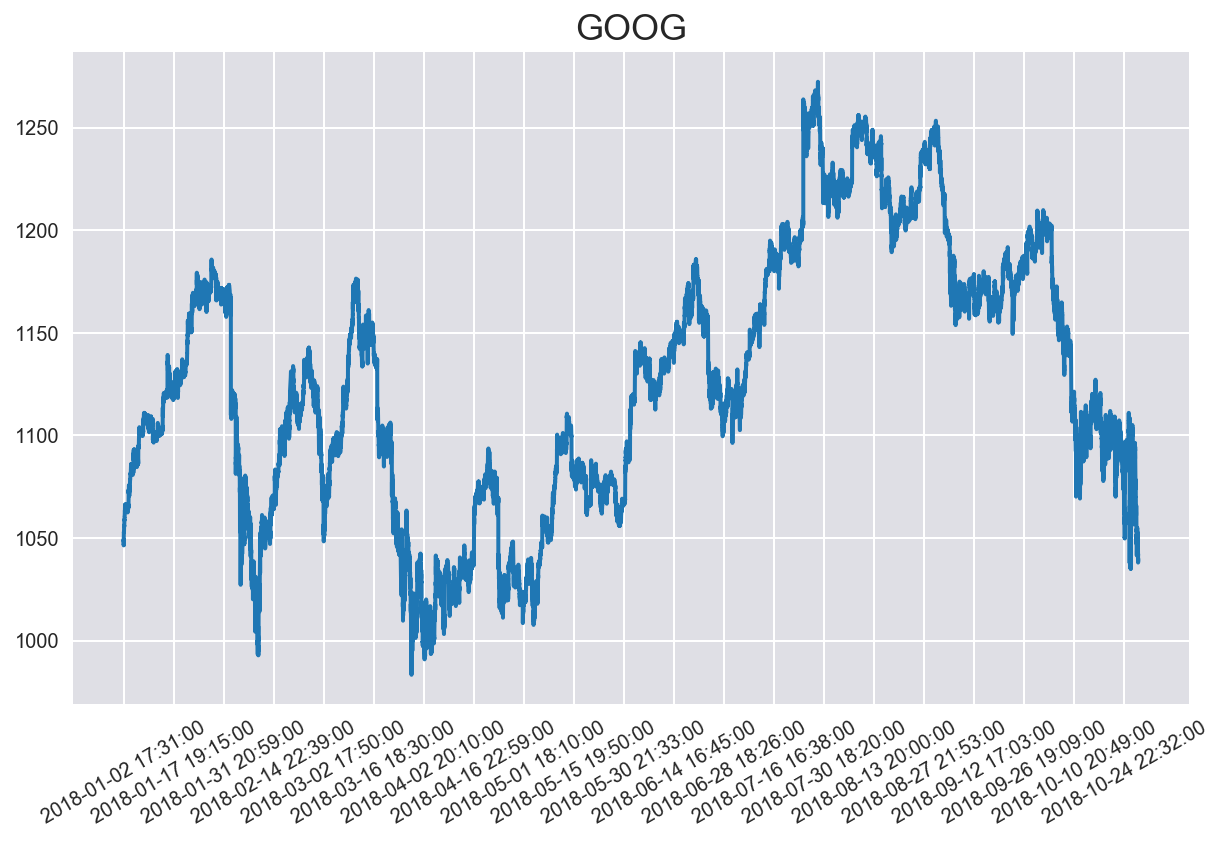

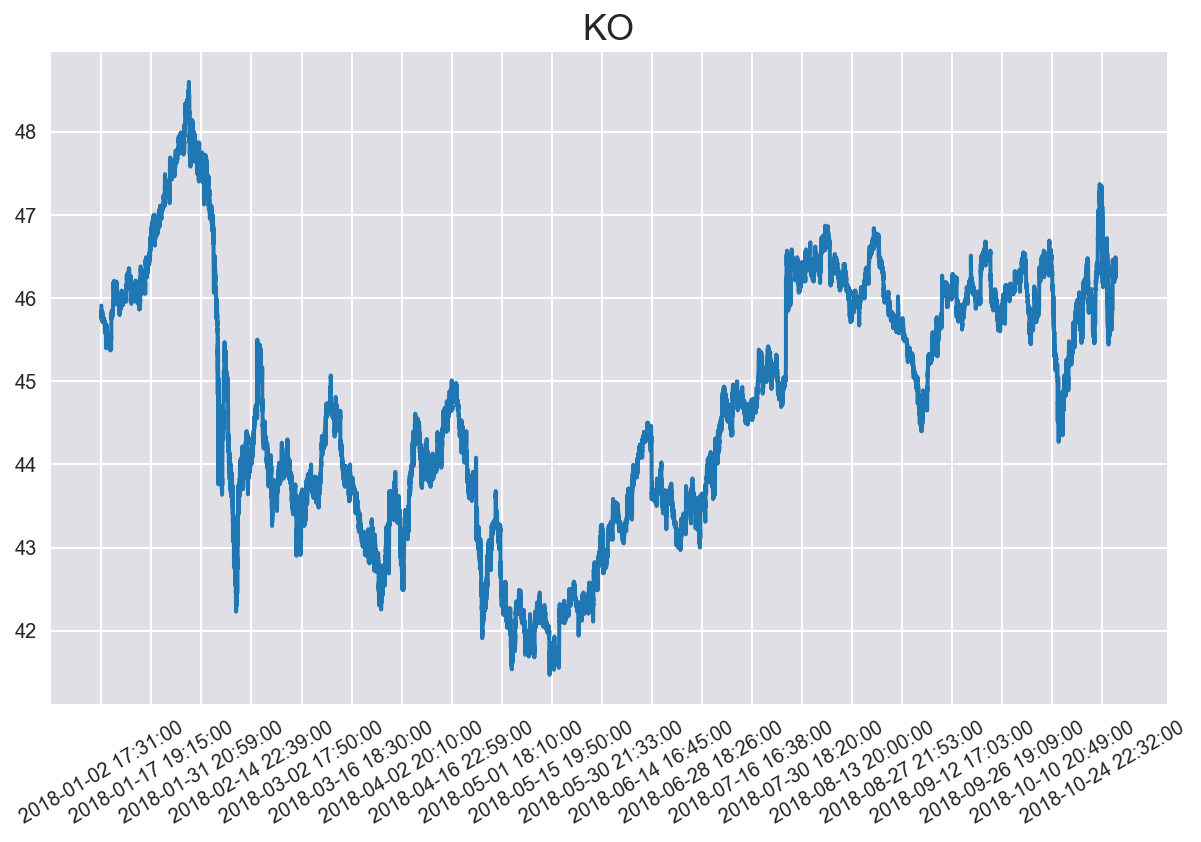

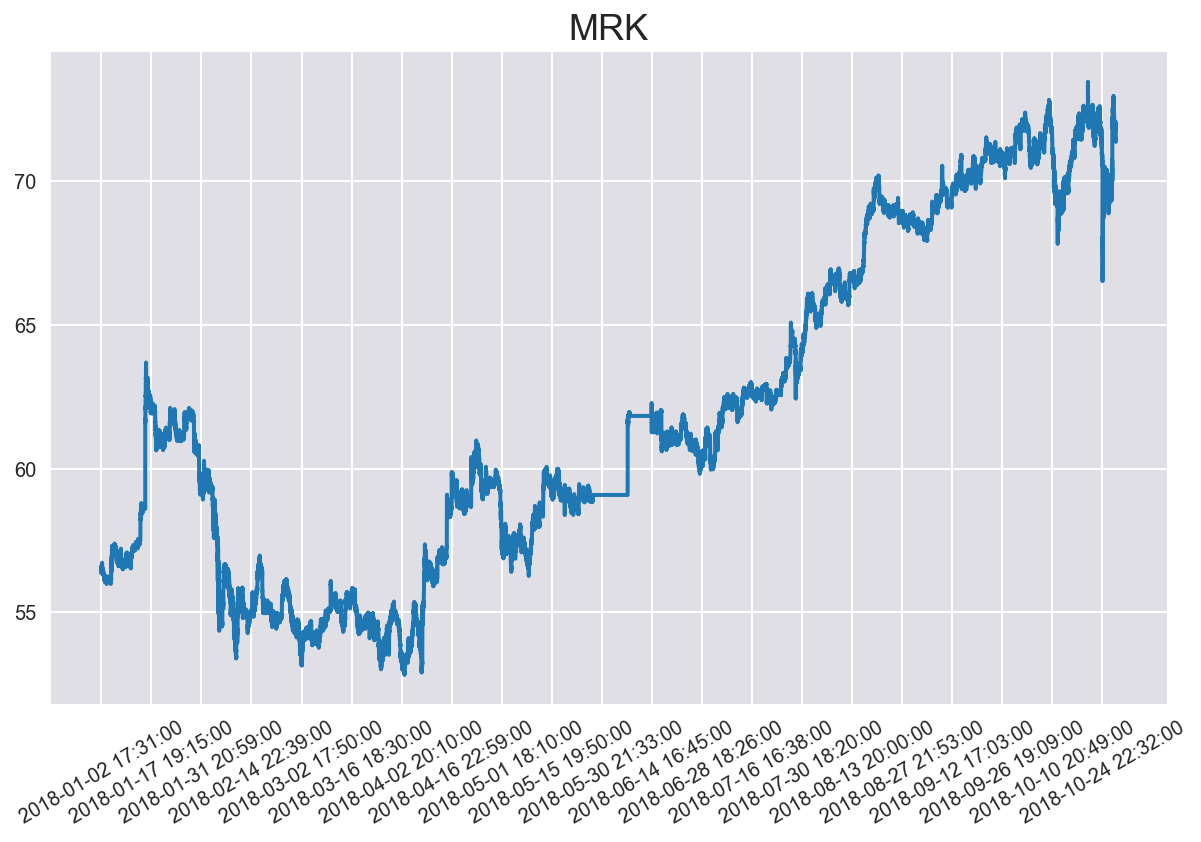

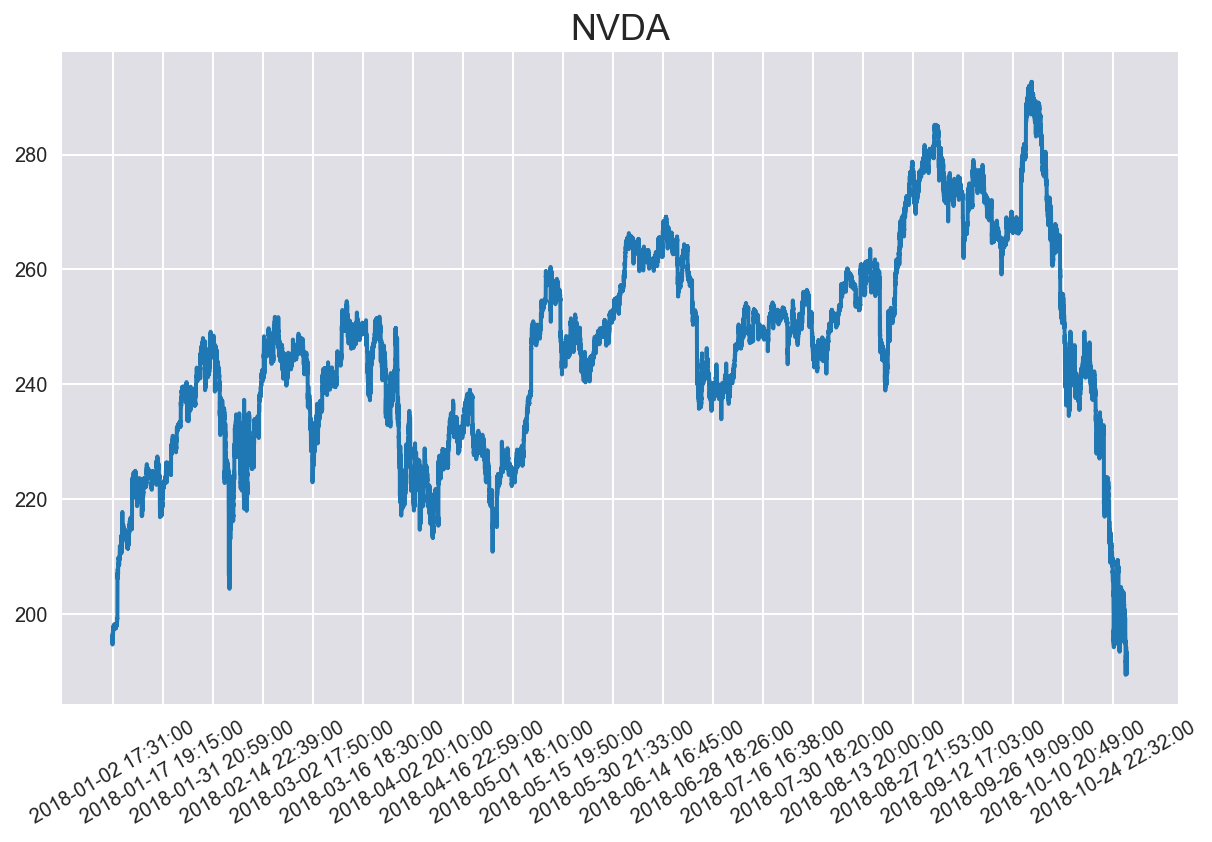

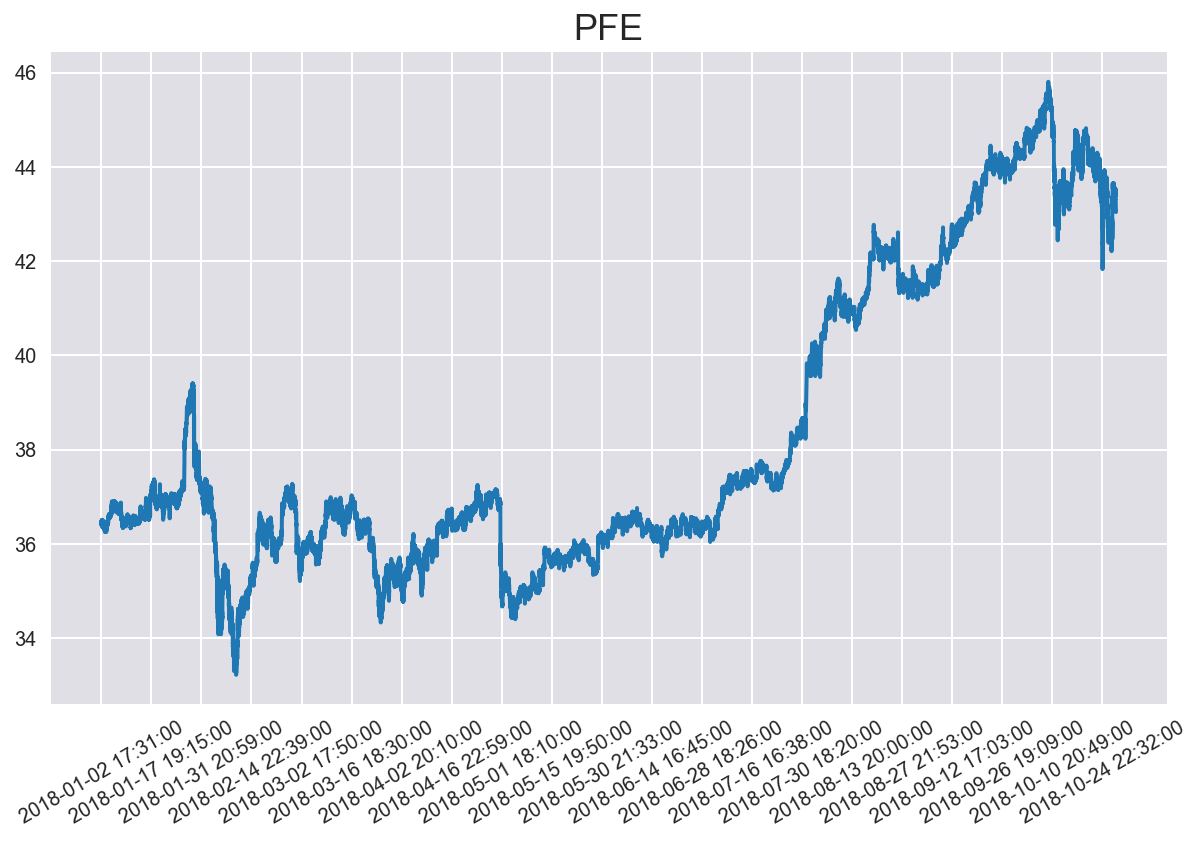

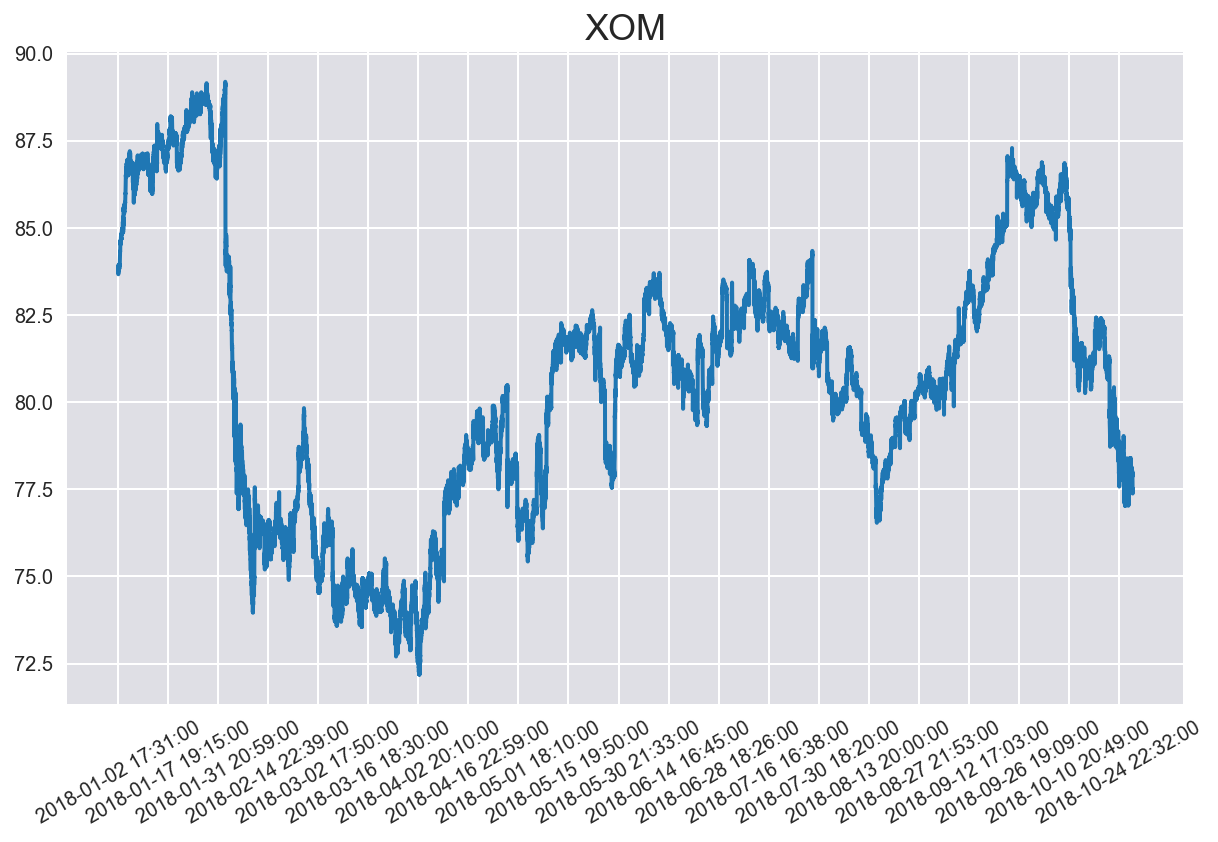

In [15]:
# visualize stocks open price from 2018-01-01 to 2018-10-29
if True:
    date = dataset.Time
    x = range(history.shape[1])
    for i in range(len(abbreviation)):
        plt.figure(i)
        plt.plot(x, history[i, :, 0])  # open, cloase, high, low, volume = [0, 1, 2, 3, 4]
        plt.xticks(x[::4000], date[::4000], rotation=30)
        plt.title(abbreviation.iloc[i, 0])
        plt.show()

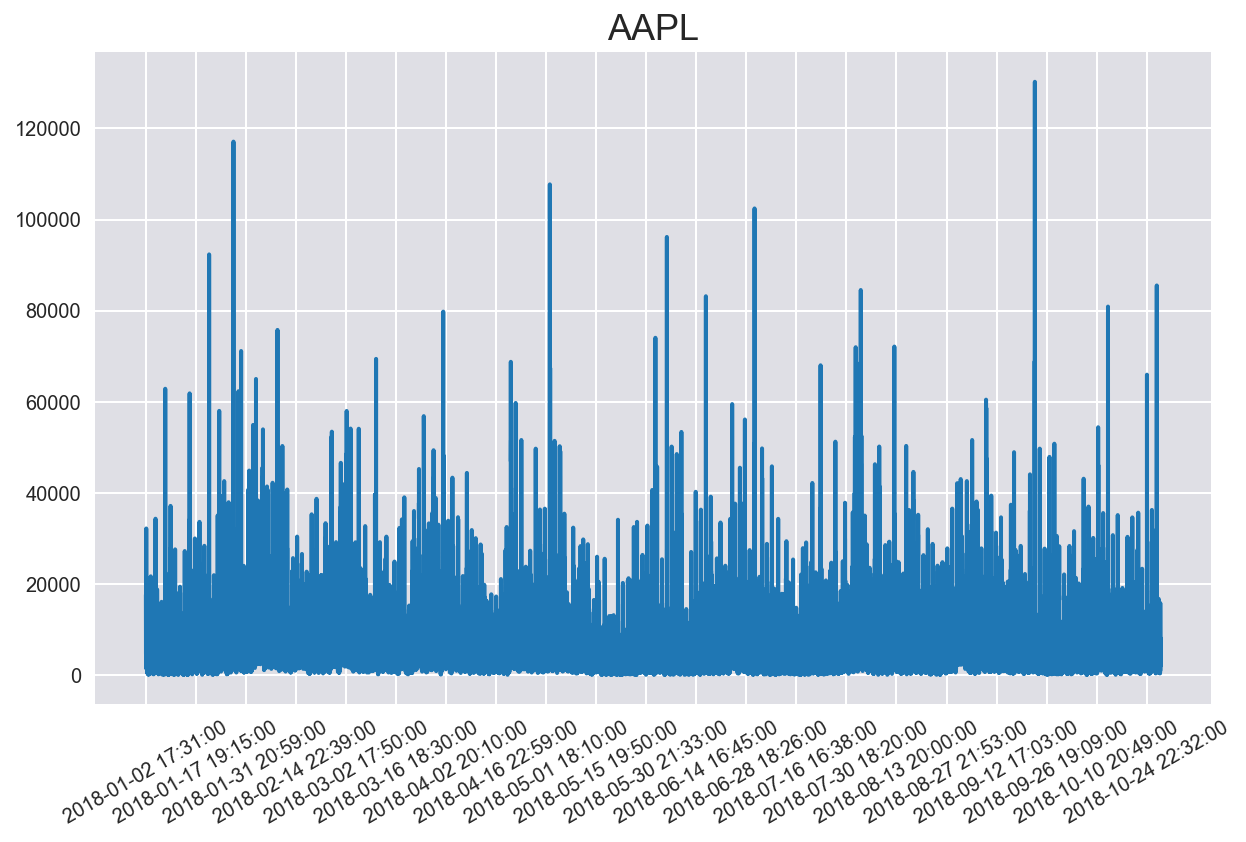

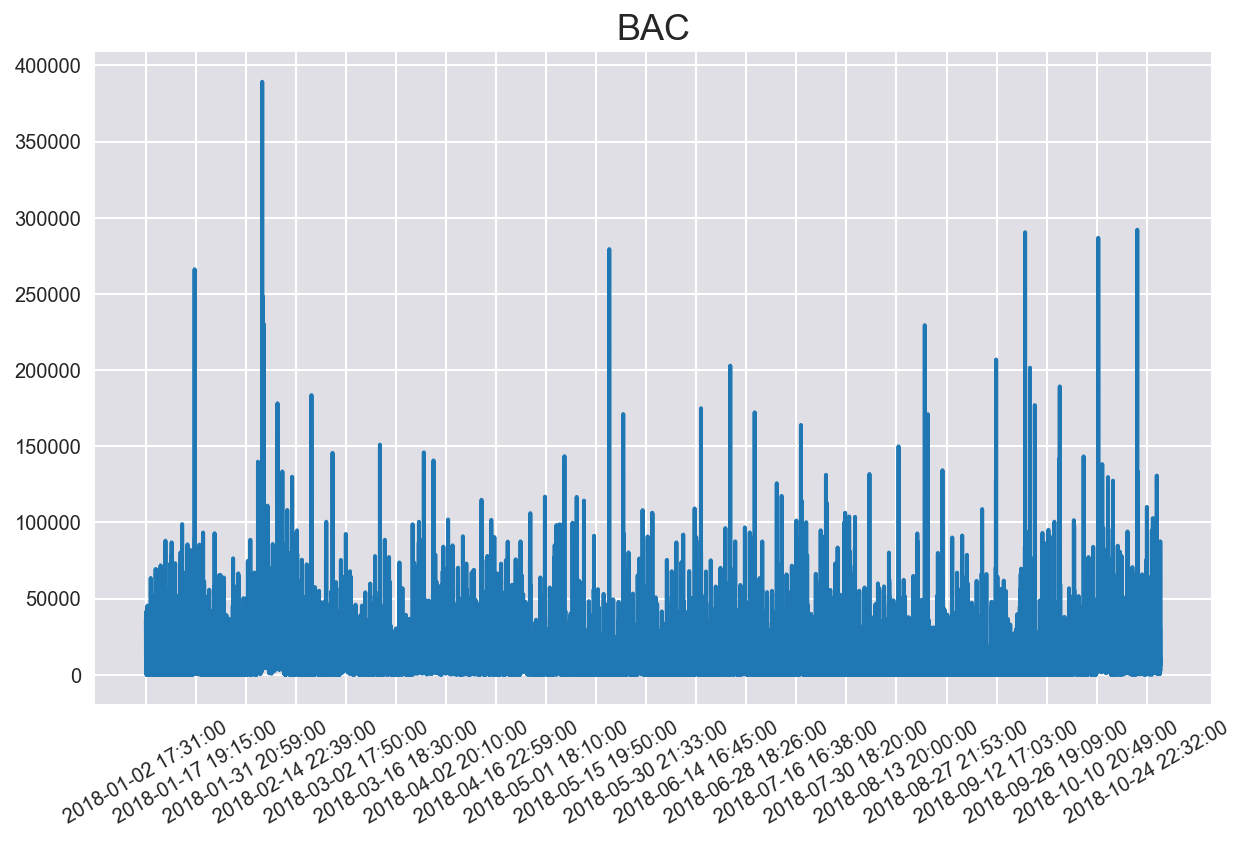

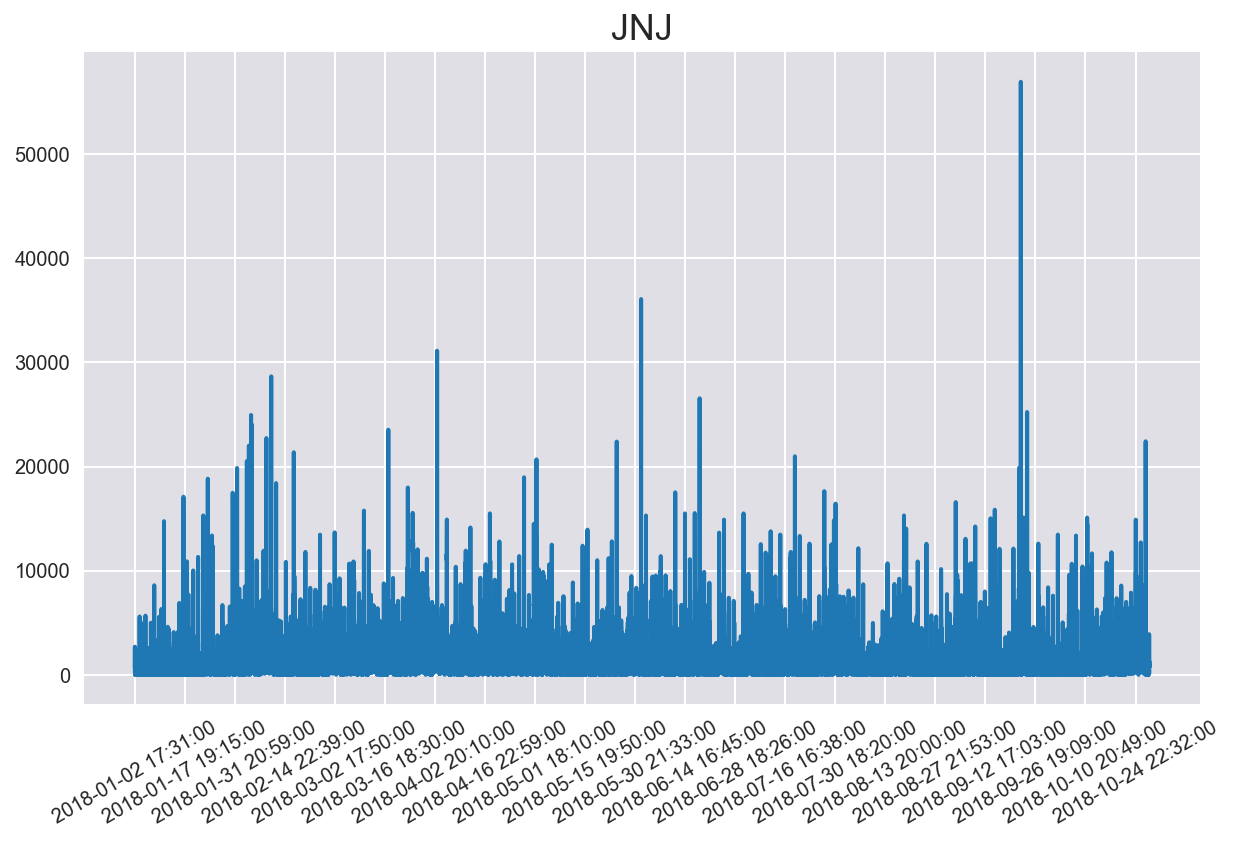

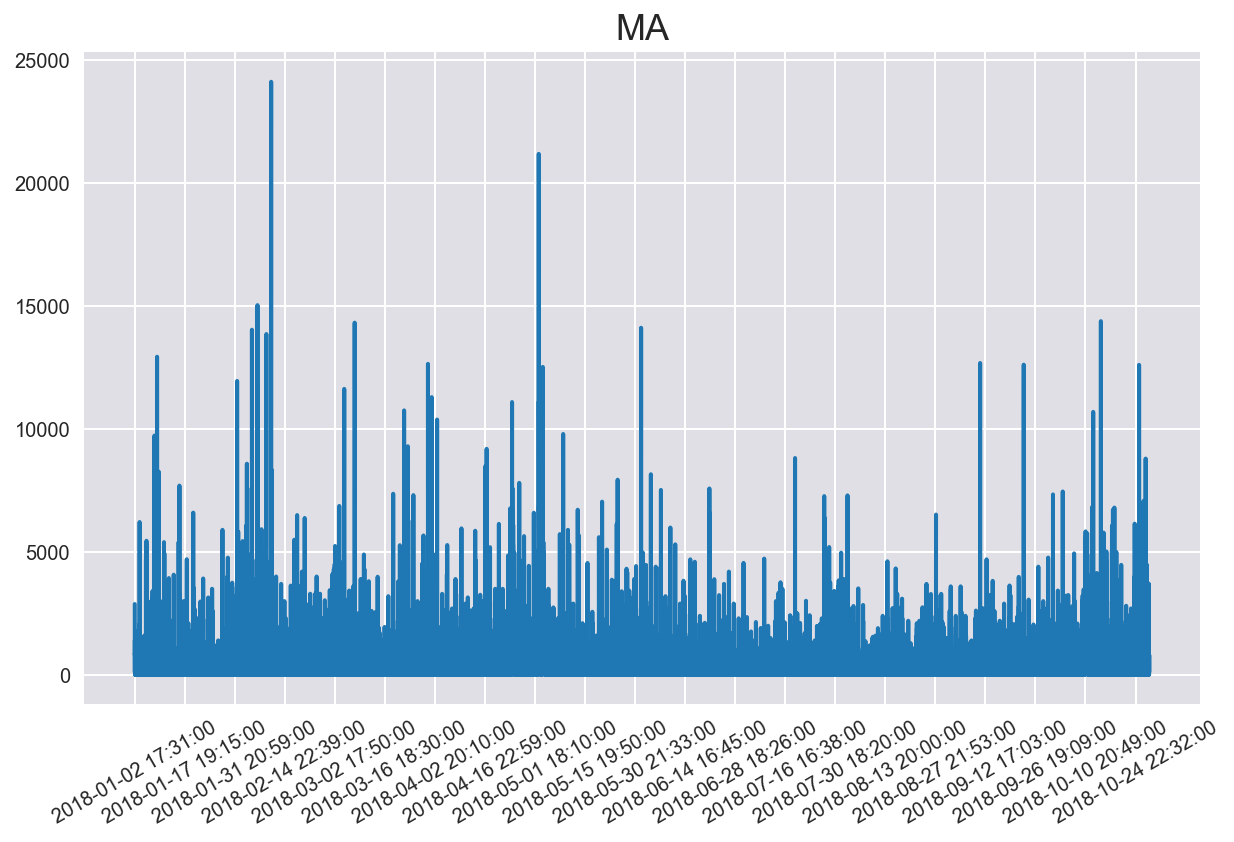

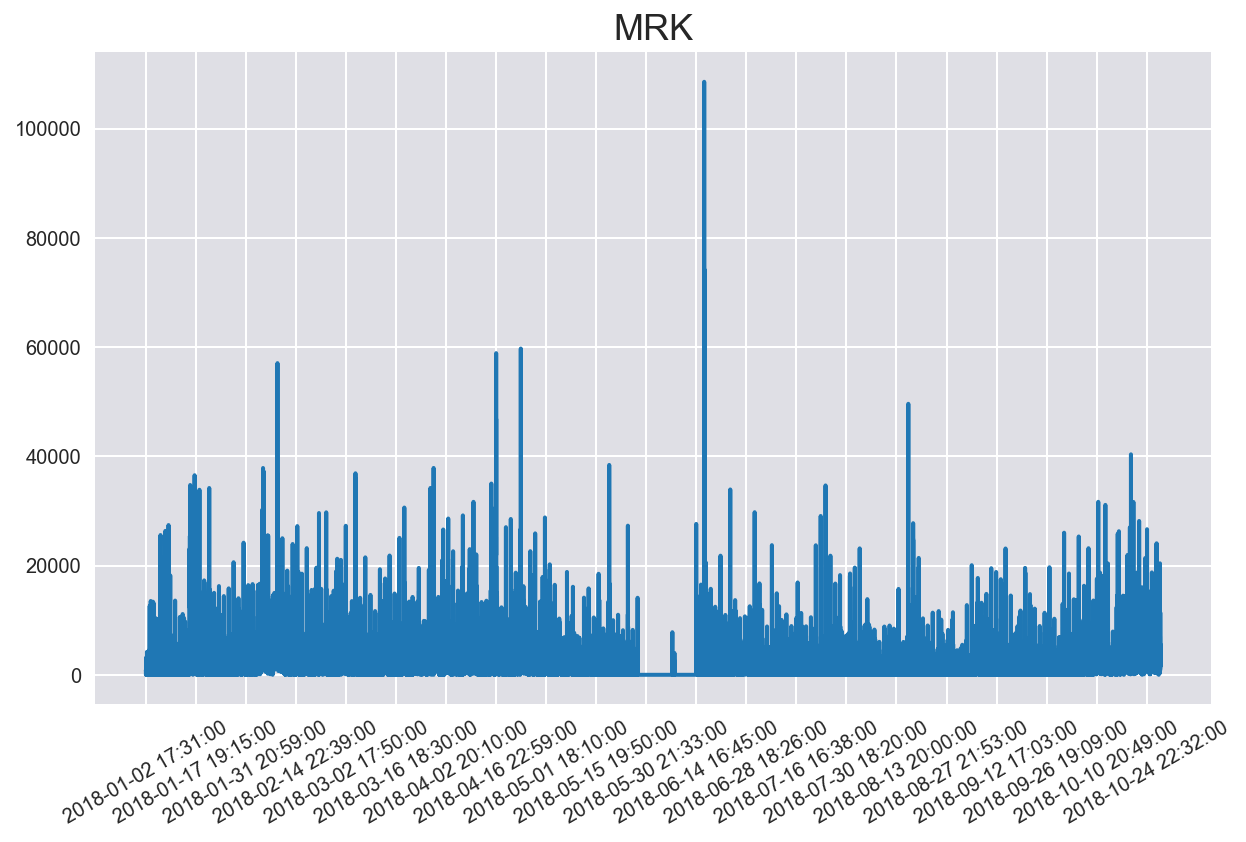

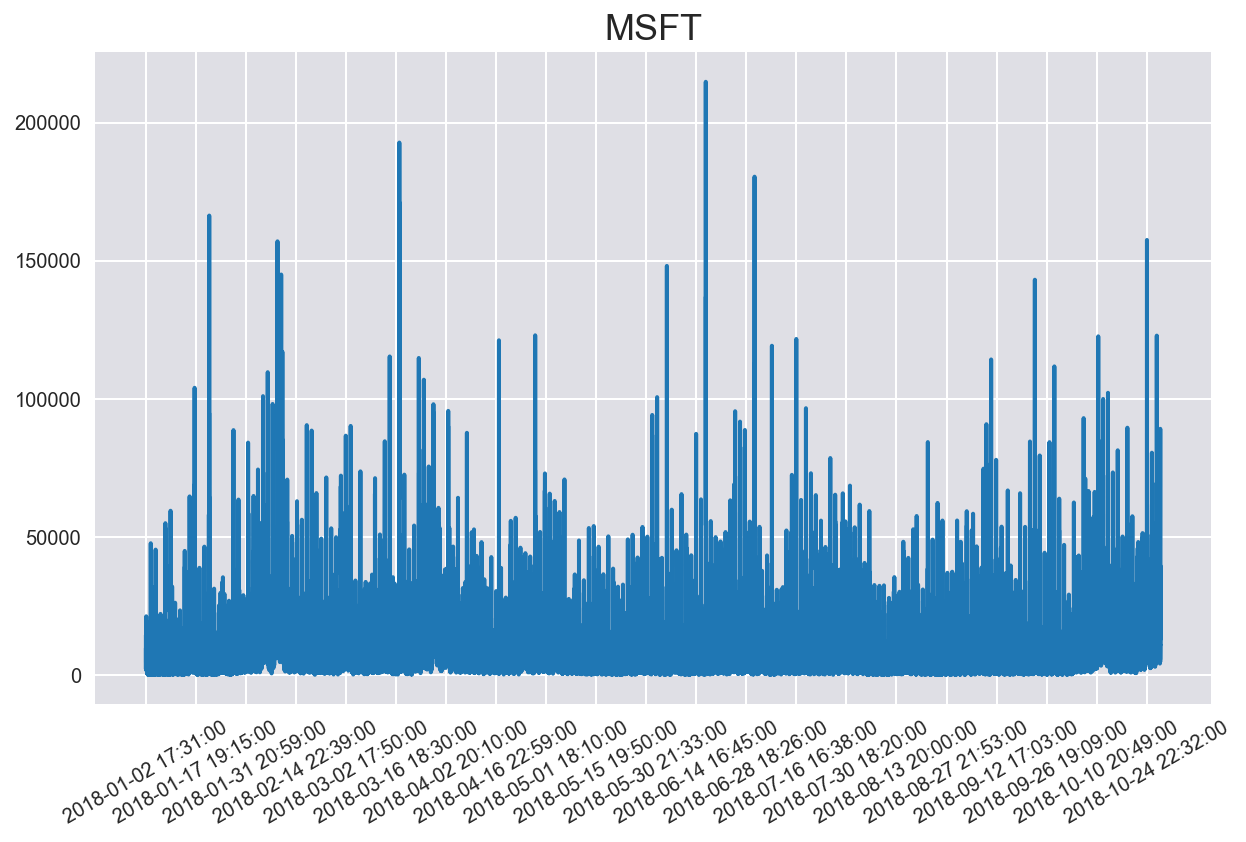

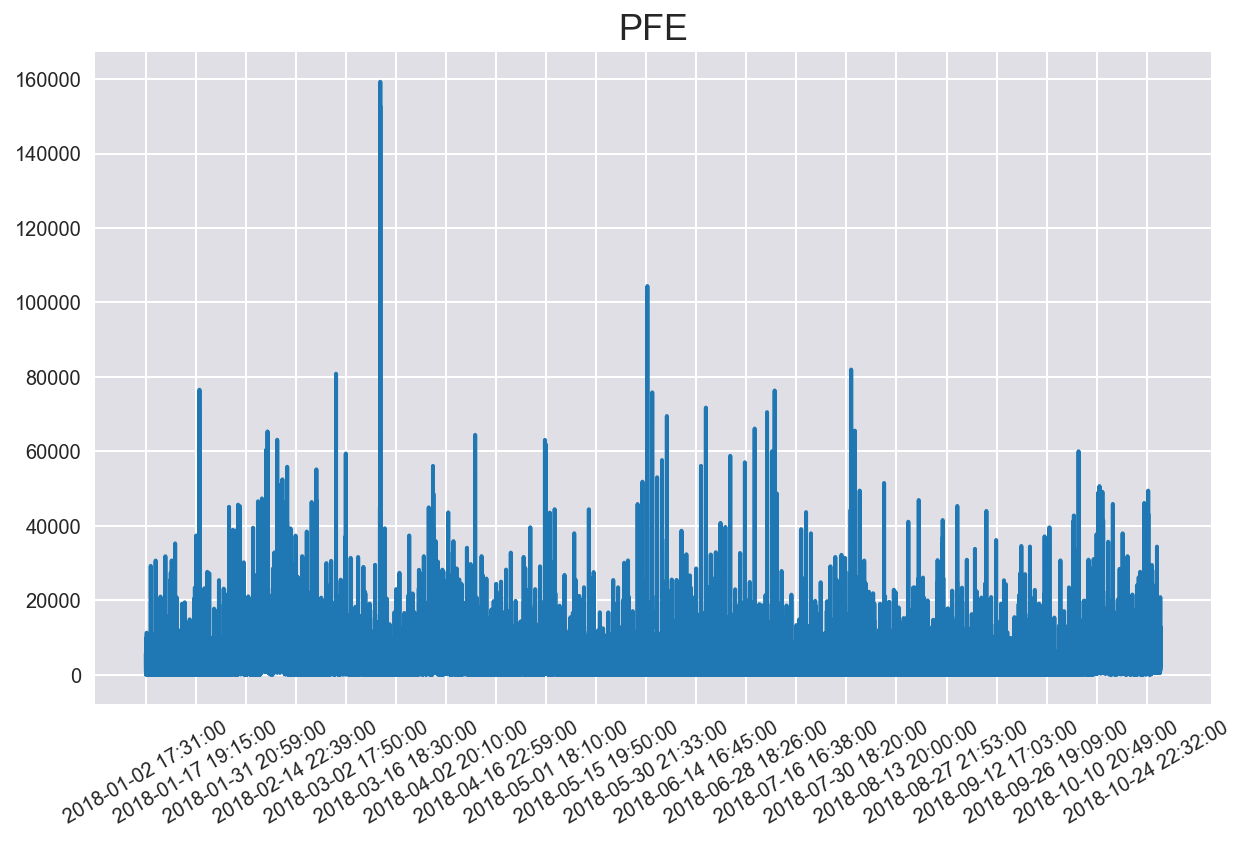

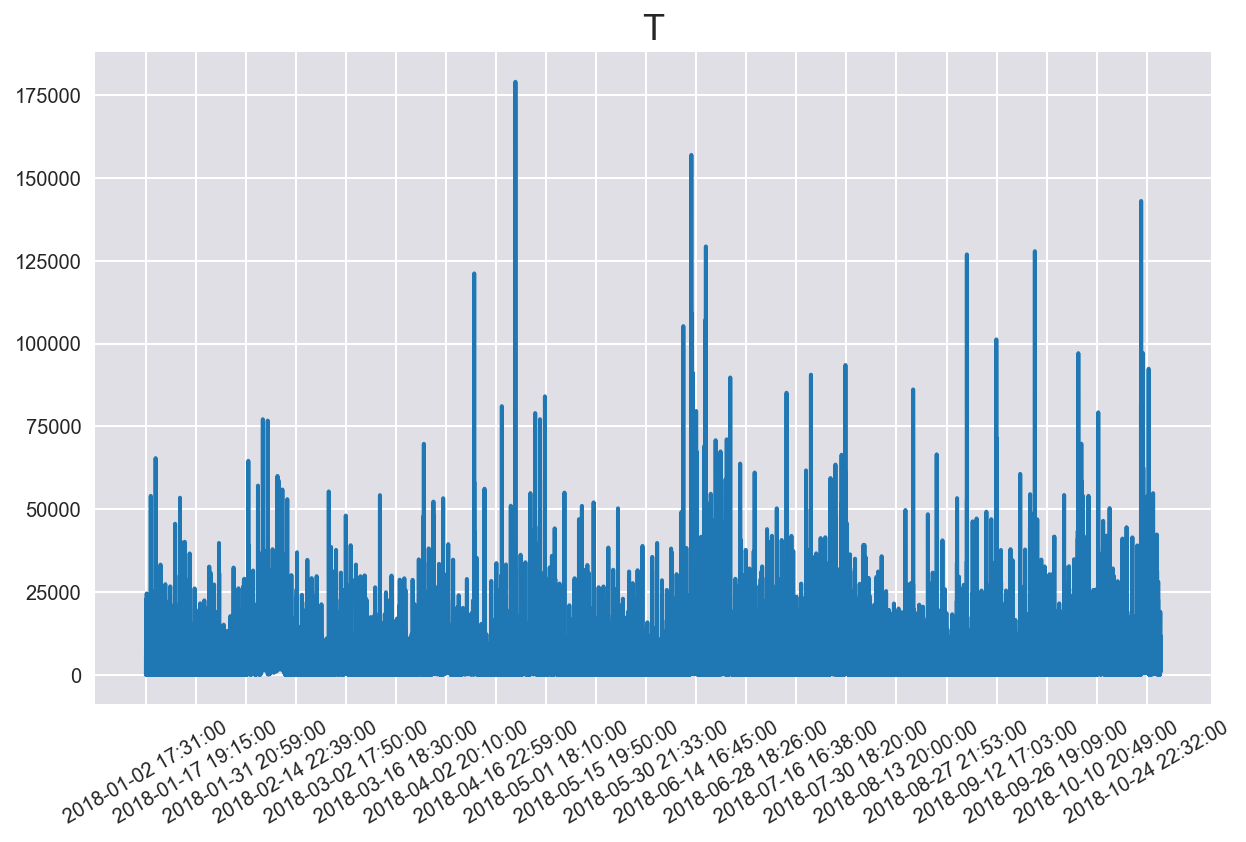

In [16]:
# visualize stocks trade volume
if True:
    date = dataset.Time
    x = range(history.shape[1])
    for i in range(len(abbreviation)):
        plt.figure(i)
        plt.plot(x, history[i, :, 4])  # open, cloase, high, low, volume = [0, 1, 2, 3, 4]
        plt.xticks(x[::4000], date[::4000], rotation=30)
        plt.title(abbreviation.iloc[i, 0])
        plt.show()

In [17]:
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn
import tensorflow as tf

from stock_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path, \
                          test_model, get_variable_scope

from environment.portfolio import PortfolioEnv

D:\ANACONDA\envs\Tensorflow_1.9\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


 Train the DDPG model with stock price data every month and play in the next month.

In [18]:
data = {
    'Jan': dataset[(dataset.Time <= pd.Timestamp(2018, 1, 31)) & (dataset.Time >= pd.Timestamp(2018, 1, 1))],
    'Feb': dataset[(dataset.Time <= pd.Timestamp(2018, 2, 28)) & (dataset.Time >= pd.Timestamp(2018, 2, 1))],
    'Mar': dataset[(dataset.Time <= pd.Timestamp(2018, 3, 31)) & (dataset.Time >= pd.Timestamp(2018, 3, 1))],
    'Apr': dataset[(dataset.Time <= pd.Timestamp(2018, 4, 30)) & (dataset.Time >= pd.Timestamp(2018, 4, 1))],
    'May': dataset[(dataset.Time <= pd.Timestamp(2018, 5, 31)) & (dataset.Time >= pd.Timestamp(2018, 5, 1))],
    'Jun': dataset[(dataset.Time <= pd.Timestamp(2018, 6, 30)) & (dataset.Time >= pd.Timestamp(2018, 6, 1))],
    'Jul': dataset[(dataset.Time <= pd.Timestamp(2018, 7, 31)) & (dataset.Time >= pd.Timestamp(2018, 7, 1))],
    'Aug': dataset[(dataset.Time <= pd.Timestamp(2018, 8, 31)) & (dataset.Time >= pd.Timestamp(2018, 8, 1))],
    'Sep': dataset[(dataset.Time <= pd.Timestamp(2018, 9, 30)) & (dataset.Time >= pd.Timestamp(2018, 9, 1))],
    'Oct': dataset[(dataset.Time <= pd.Timestamp(2018, 10, 31)) & (dataset.Time >= pd.Timestamp(2018, 10, 1))]
    }

In [19]:
data['Jan'].head(5)

Unnamed: 0  date_index      date    time  AAPL_open  AAPL_high  AAPL_low  \
0           0           0  20180102  173100     170.18     170.19    169.88   
1           1           1  20180102  173200     169.90     169.93    169.67   
2           2           2  20180102  173300     169.67     169.88    169.58   
3           3           3  20180102  173400     169.46     169.46    169.27   
4           4           4  20180102  173500     169.45     169.60    169.44   

   AAPL_close  AAPL_vol  BAC_open         ...          T_high  T_low  T_close  \
0      169.94     17654     29.80         ...           39.03  39.03    39.03   
1      169.69      8200     29.71         ...           39.03  38.97    39.00   
2      169.58      9380     29.77         ...           39.03  39.00    39.02   
3      169.33      5348     29.77         ...           39.02  38.97    38.97   
4      169.59      9700     29.74         ...           39.01  38.97    38.98   

   T_vol  XOM_open  XOM_high  XOM_low  XOM_close  XOM_vol                Time  
0      0     83.82     83.84    83.77      83.77      800 2018-01-02 17:31:00  
1   1000     83.80     83.94    83.80      83.94     1391 2018-01-02 17:32:00  
2   5376     83.90     83.93    83.84      83.90     9400 2018-01-02 17:33:00  
3   5137     83.87     83.90    83.82      83.86     8728 2018-01-02 17:34:00  
4   5499     83.88     83.89    83.79      83.79     5430 2018-01-02 17:35:00  

[5 rows x 80 columns]

In [20]:
history_Jan = np.empty((15,len(data['Jan']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Jan[i_n, :, j_n] = data['Jan'][i+j]
history_Feb = np.empty((15,len(data['Feb']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Feb[i_n, :, j_n] = data['Feb'][i+j]
history_Mar = np.empty((15,len(data['Mar']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Mar[i_n, :, j_n] = data['Mar'][i+j]
history_Apr = np.empty((15,len(data['Apr']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Apr[i_n, :, j_n] = data['Apr'][i+j]
history_May = np.empty((15,len(data['May']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_May[i_n, :, j_n] = data['May'][i+j]
history_Jun = np.empty((15,len(data['Jun']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Jun[i_n, :, j_n] = data['Jun'][i+j]
history_Jul = np.empty((15,len(data['Jul']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Jul[i_n, :, j_n] = data['Jul'][i+j]
history_Aug = np.empty((15,len(data['Aug']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Aug[i_n, :, j_n] = data['Aug'][i+j]
history_Sep = np.empty((15,len(data['Sep']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Sep[i_n, :, j_n] = data['Sep'][i+j]
history_Oct = np.empty((15,len(data['Oct']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Oct[i_n, :, j_n] = data['Oct'][i+j]

In [21]:
batch_size = 100
action_bound = 1.
tau = 1e-3
window_length = 30
predictor_type = 'lstm'
use_batch_norm = True
nb_classes = 15

In [22]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/stock/lstm/window_30/batch_norm/Model_Jan/checkpoint.ckpt_Episode_1500/checkpoint.ckpt"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                      config_file='config/stock.json', model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=True, verbose=False)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Jan/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


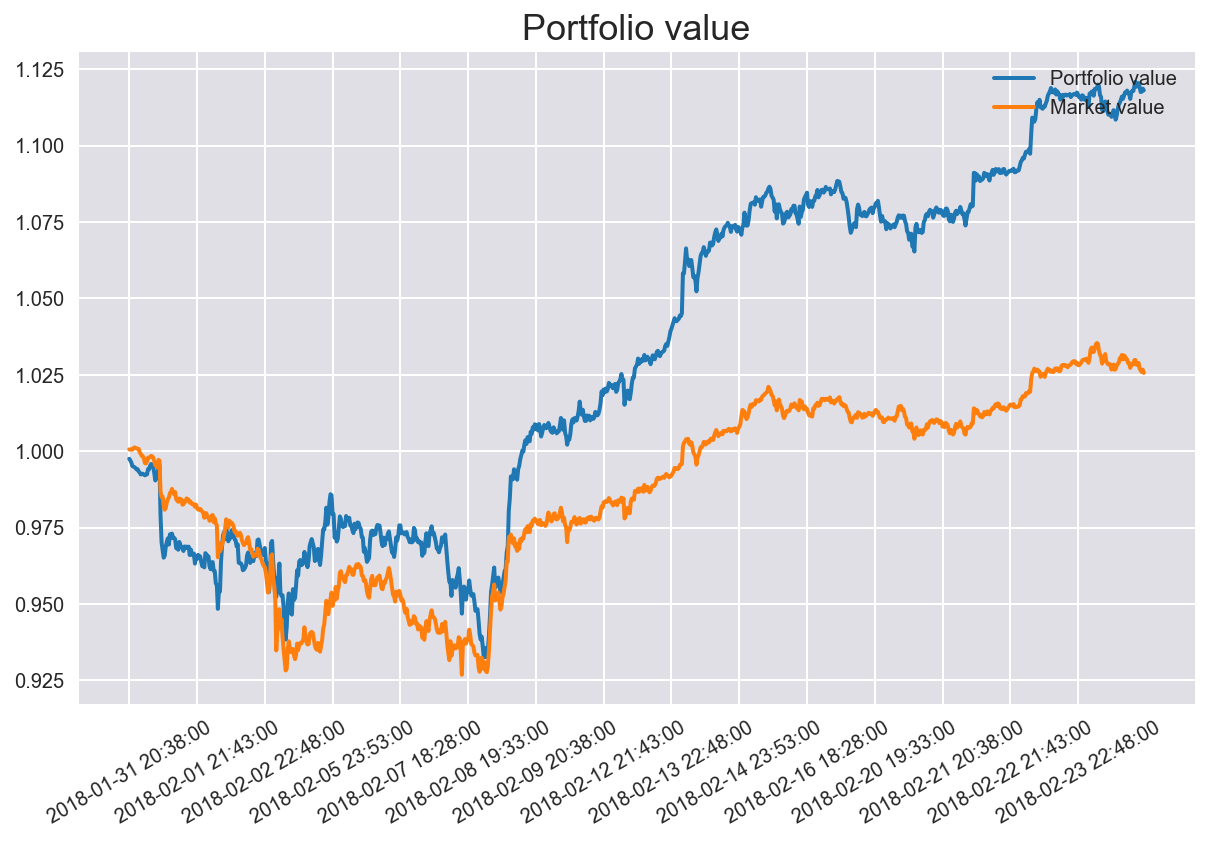

In [23]:
env_Feb = PortfolioEnv(history_Feb, abbreviation, steps=history_Feb.shape[1]-200, window_length=window_length,
                   start_idx=data['Feb'].date_index.iloc[0])
test_model(env_Feb, ddpg_model)

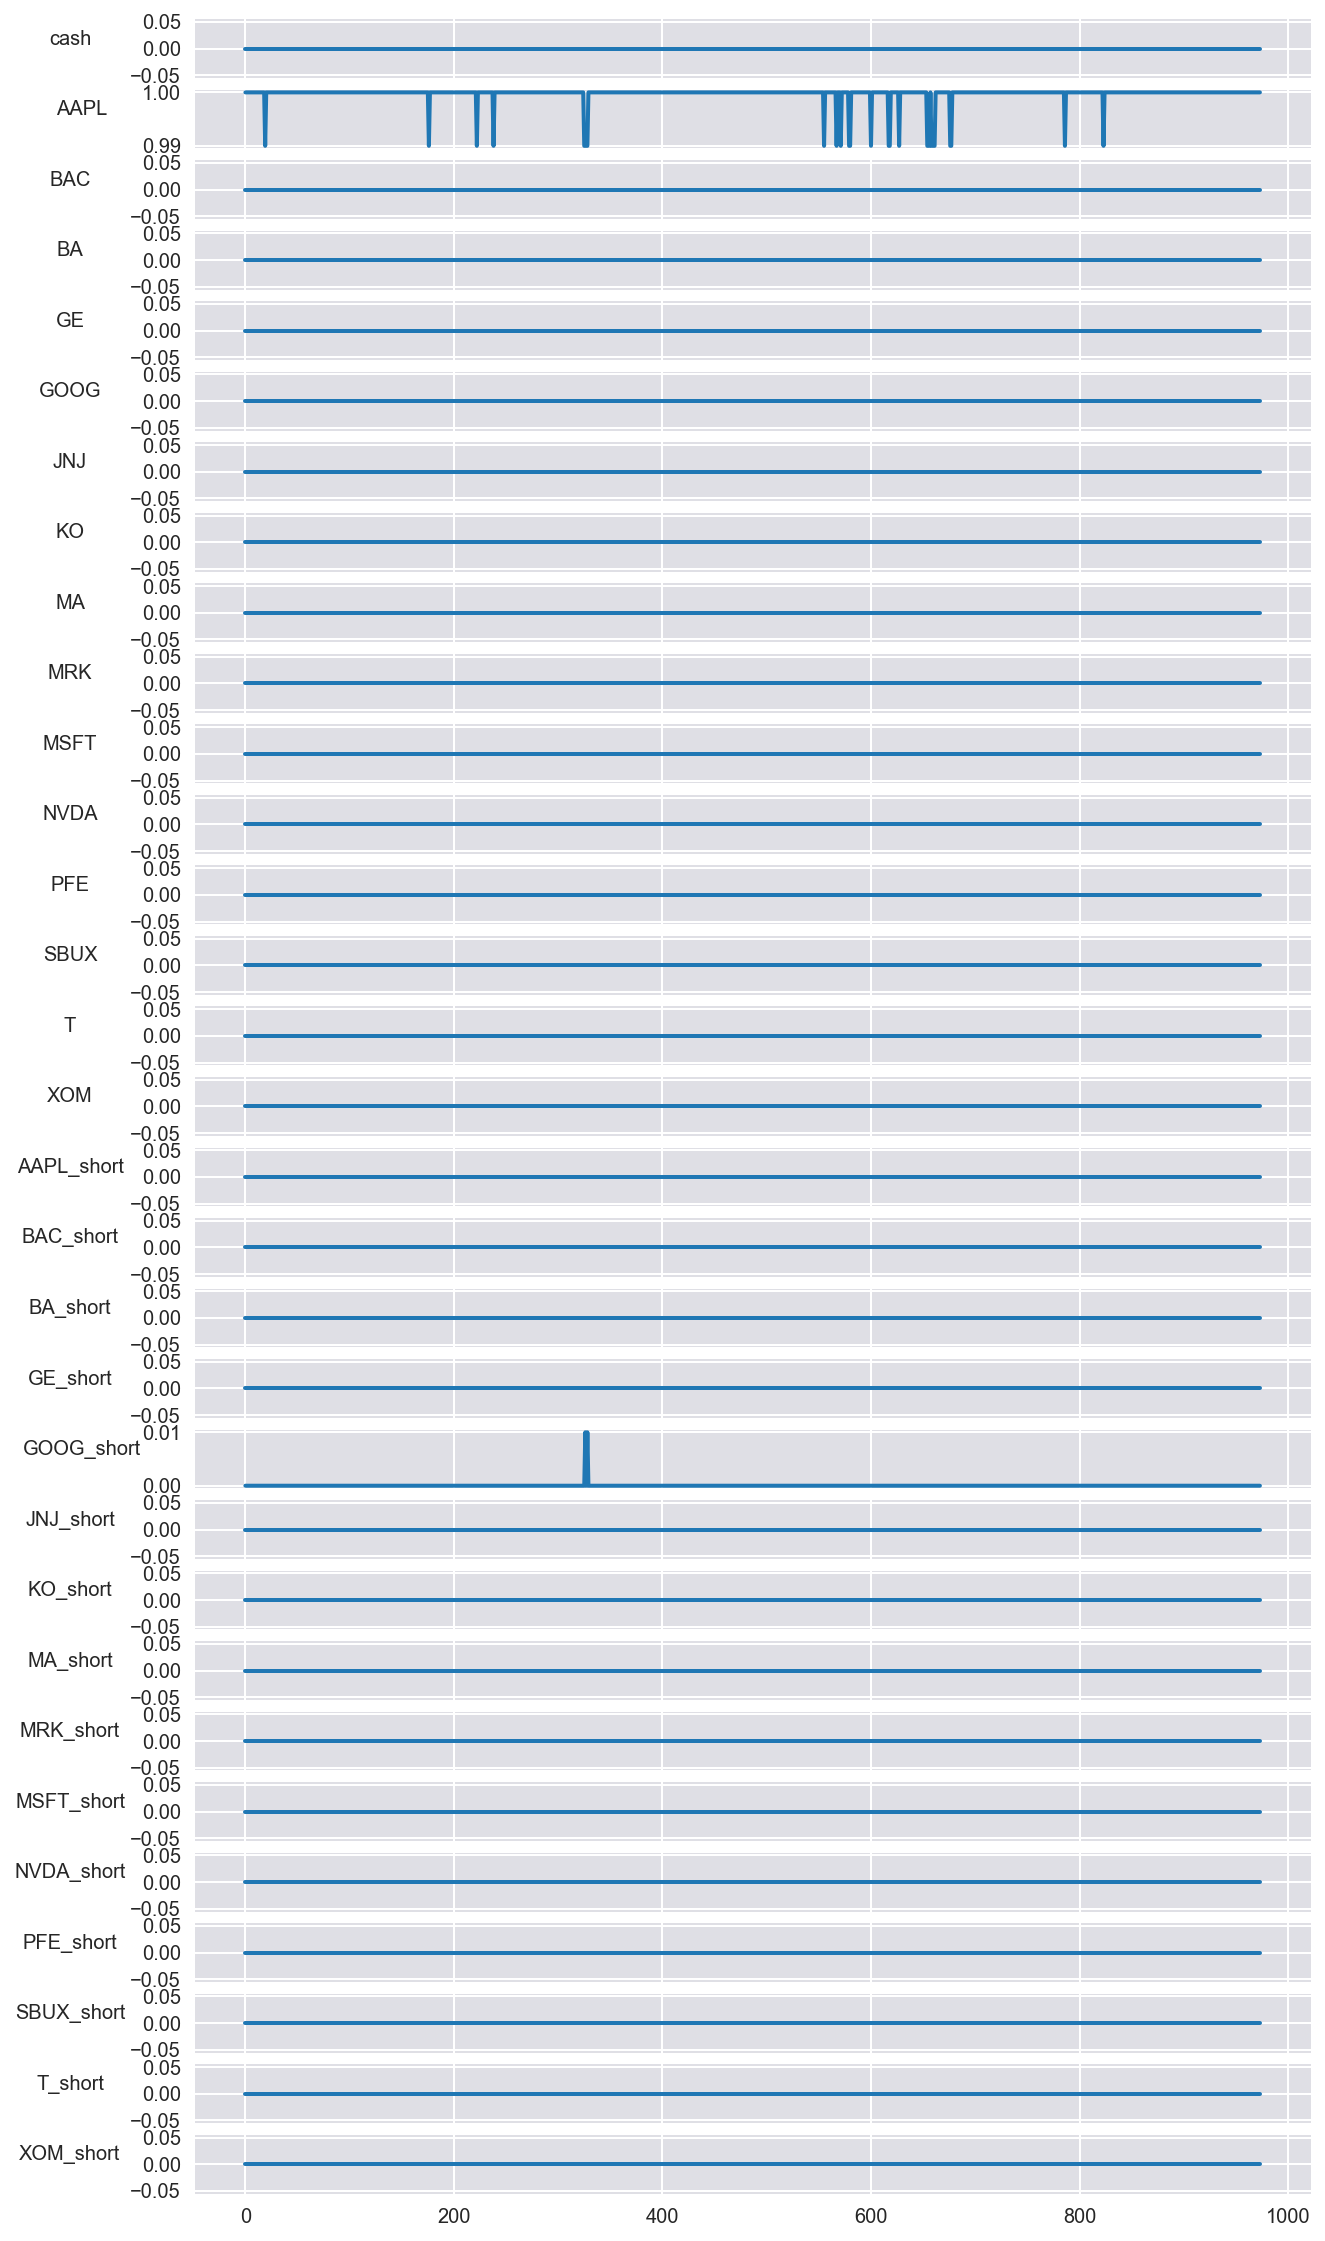

In [24]:
def plot_weights(env_infos):
    weights_change = np.empty((31,len(env_infos)))
    for i in range(len(env_infos)):
        weights_change[:, i] = env_infos[i]['weights']
    long_position = list(abbreviation.iloc[:, 0])
    short_position = []
    for i in long_position:
        short_position.append(i + '_short')
    ylabel = ['cash'] + long_position + short_position
    plt.figure(figsize=(10,20))
    for i in range(31):
        plt.subplot(31, 1, i+1)
        plt.plot(np.round(weights_change[i, :], decimals=2))
        h = plt.ylabel(ylabel[i], fontsize = 10, labelpad=30)
        h.set_rotation(0)
plot_weights(env_Feb.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Feb/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


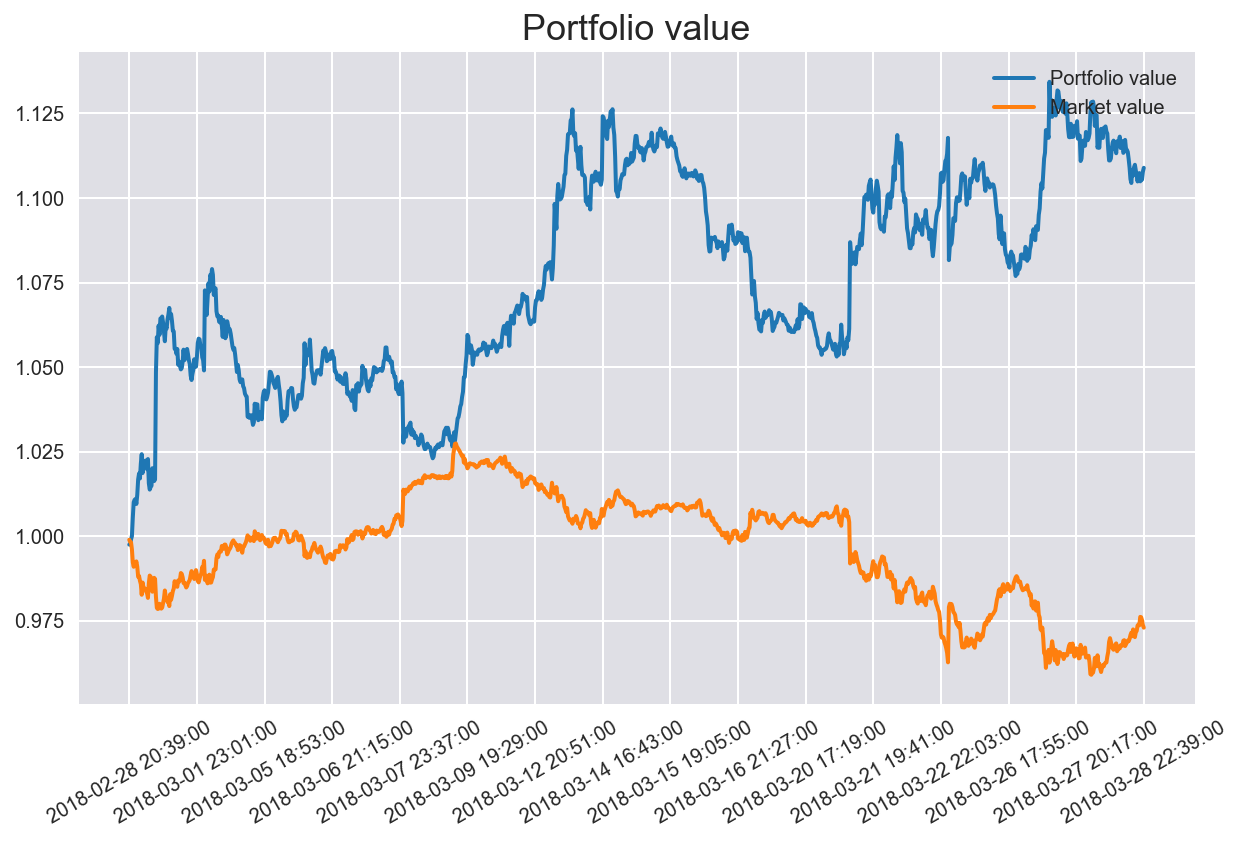

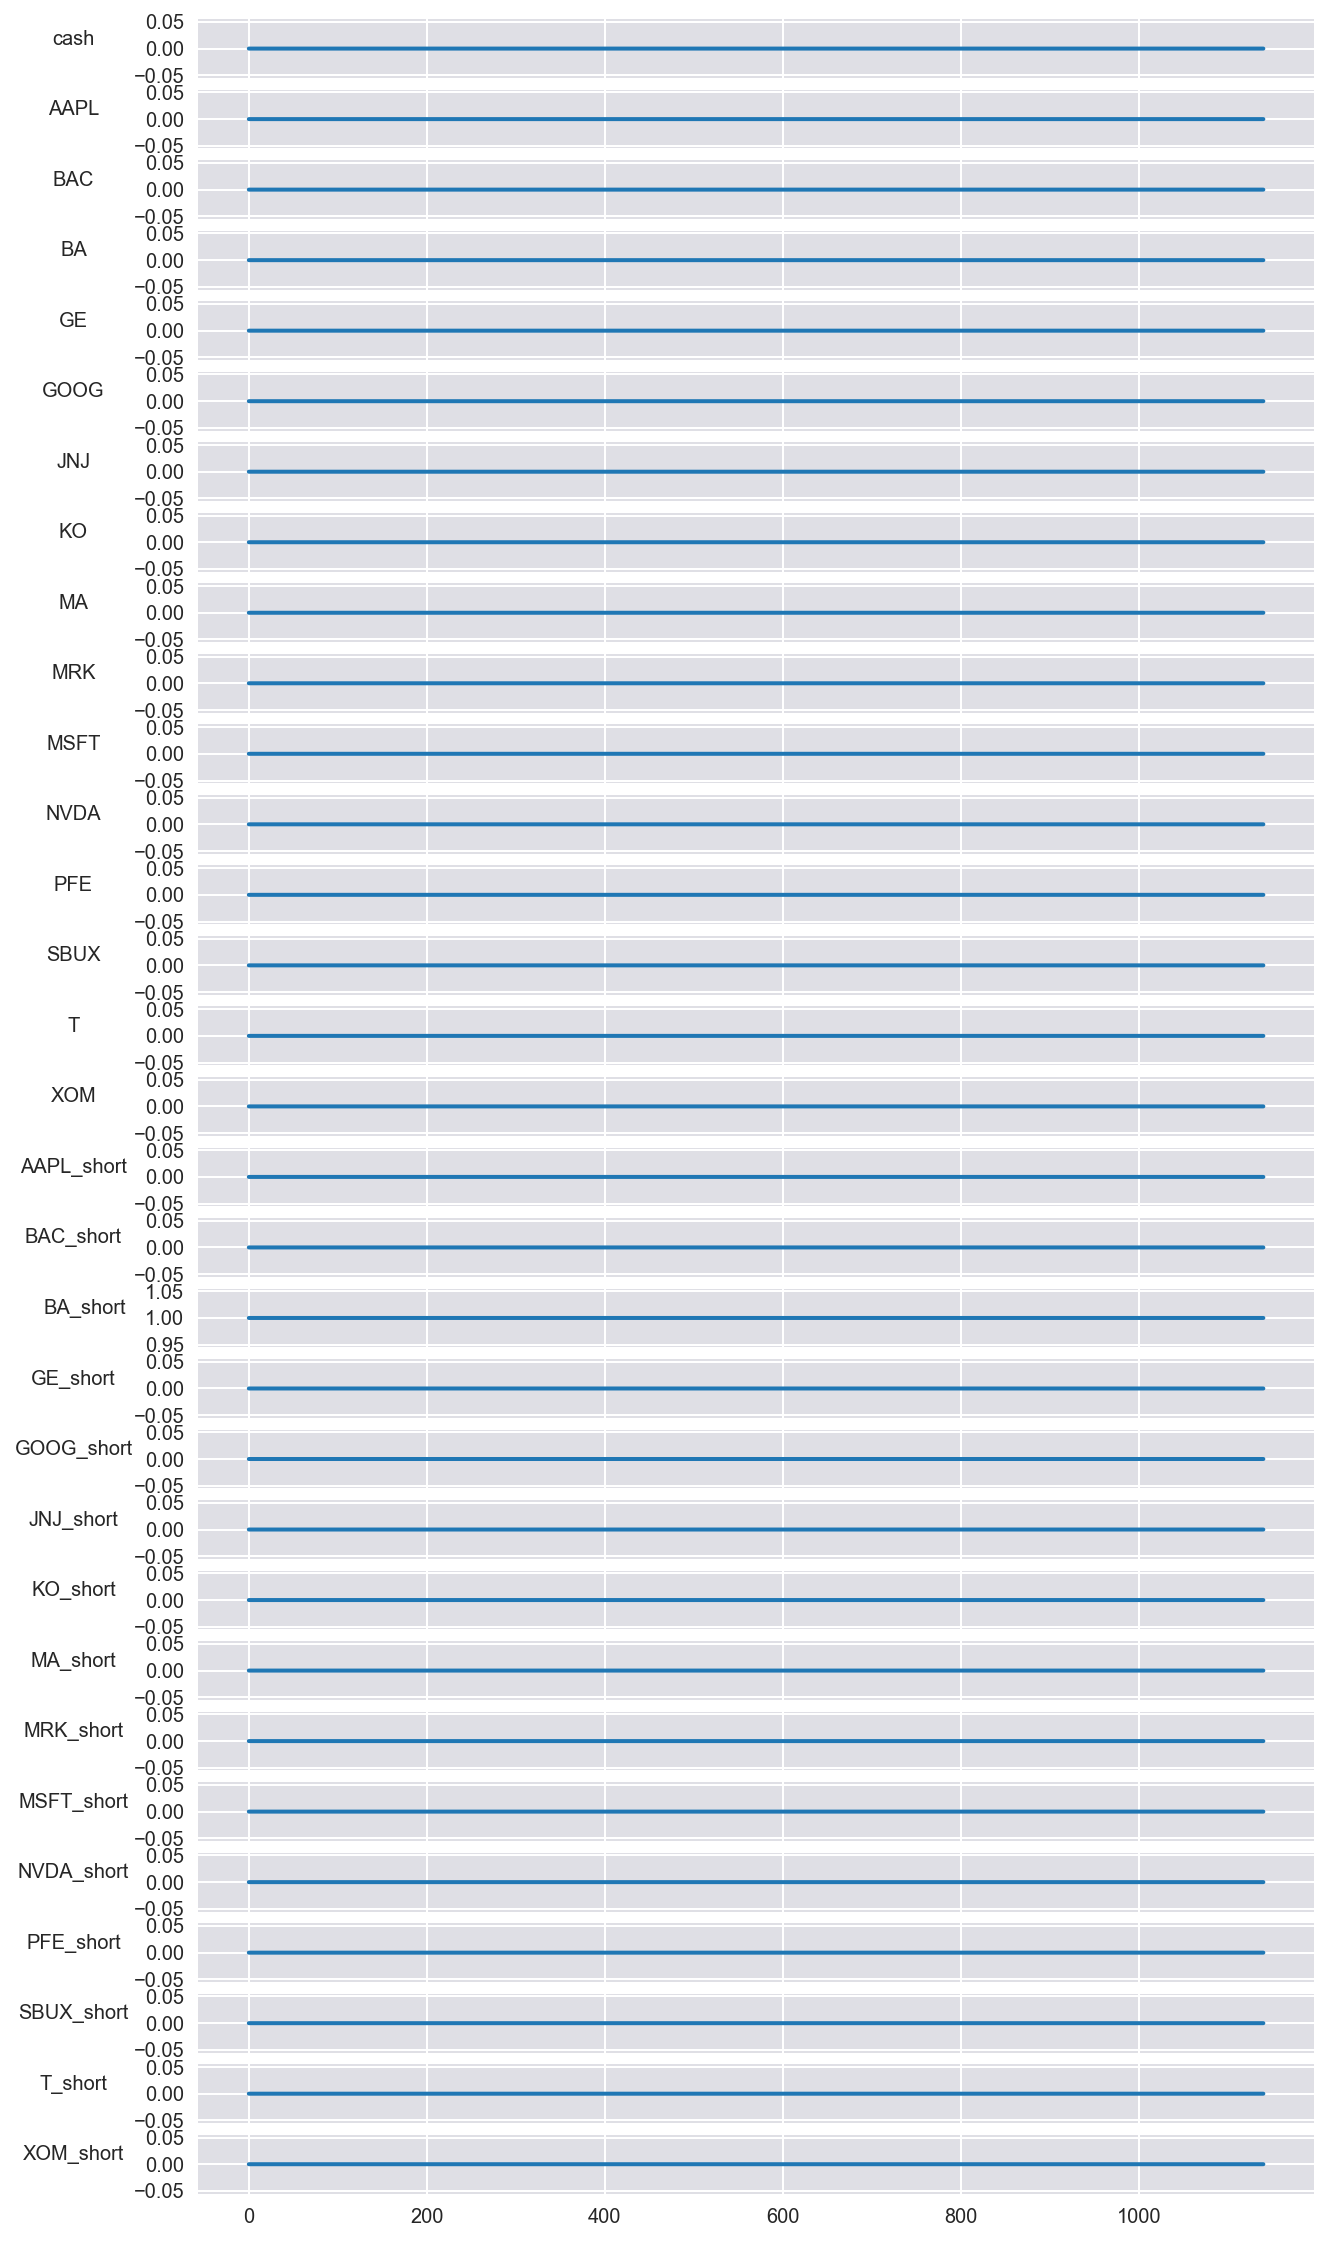

In [25]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/stock/lstm/window_30/batch_norm/Model_Feb/checkpoint.ckpt_Episode_1500/checkpoint.ckpt"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                      config_file='config/stock.json', model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=True, verbose=False)

env_Mar = PortfolioEnv(history_Mar, abbreviation, steps=history_Mar.shape[1]-200, window_length=window_length,
                   start_idx=data['Mar'].date_index.iloc[0])
test_model(env_Mar, ddpg_model)
plot_weights(env_Mar.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Mar/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


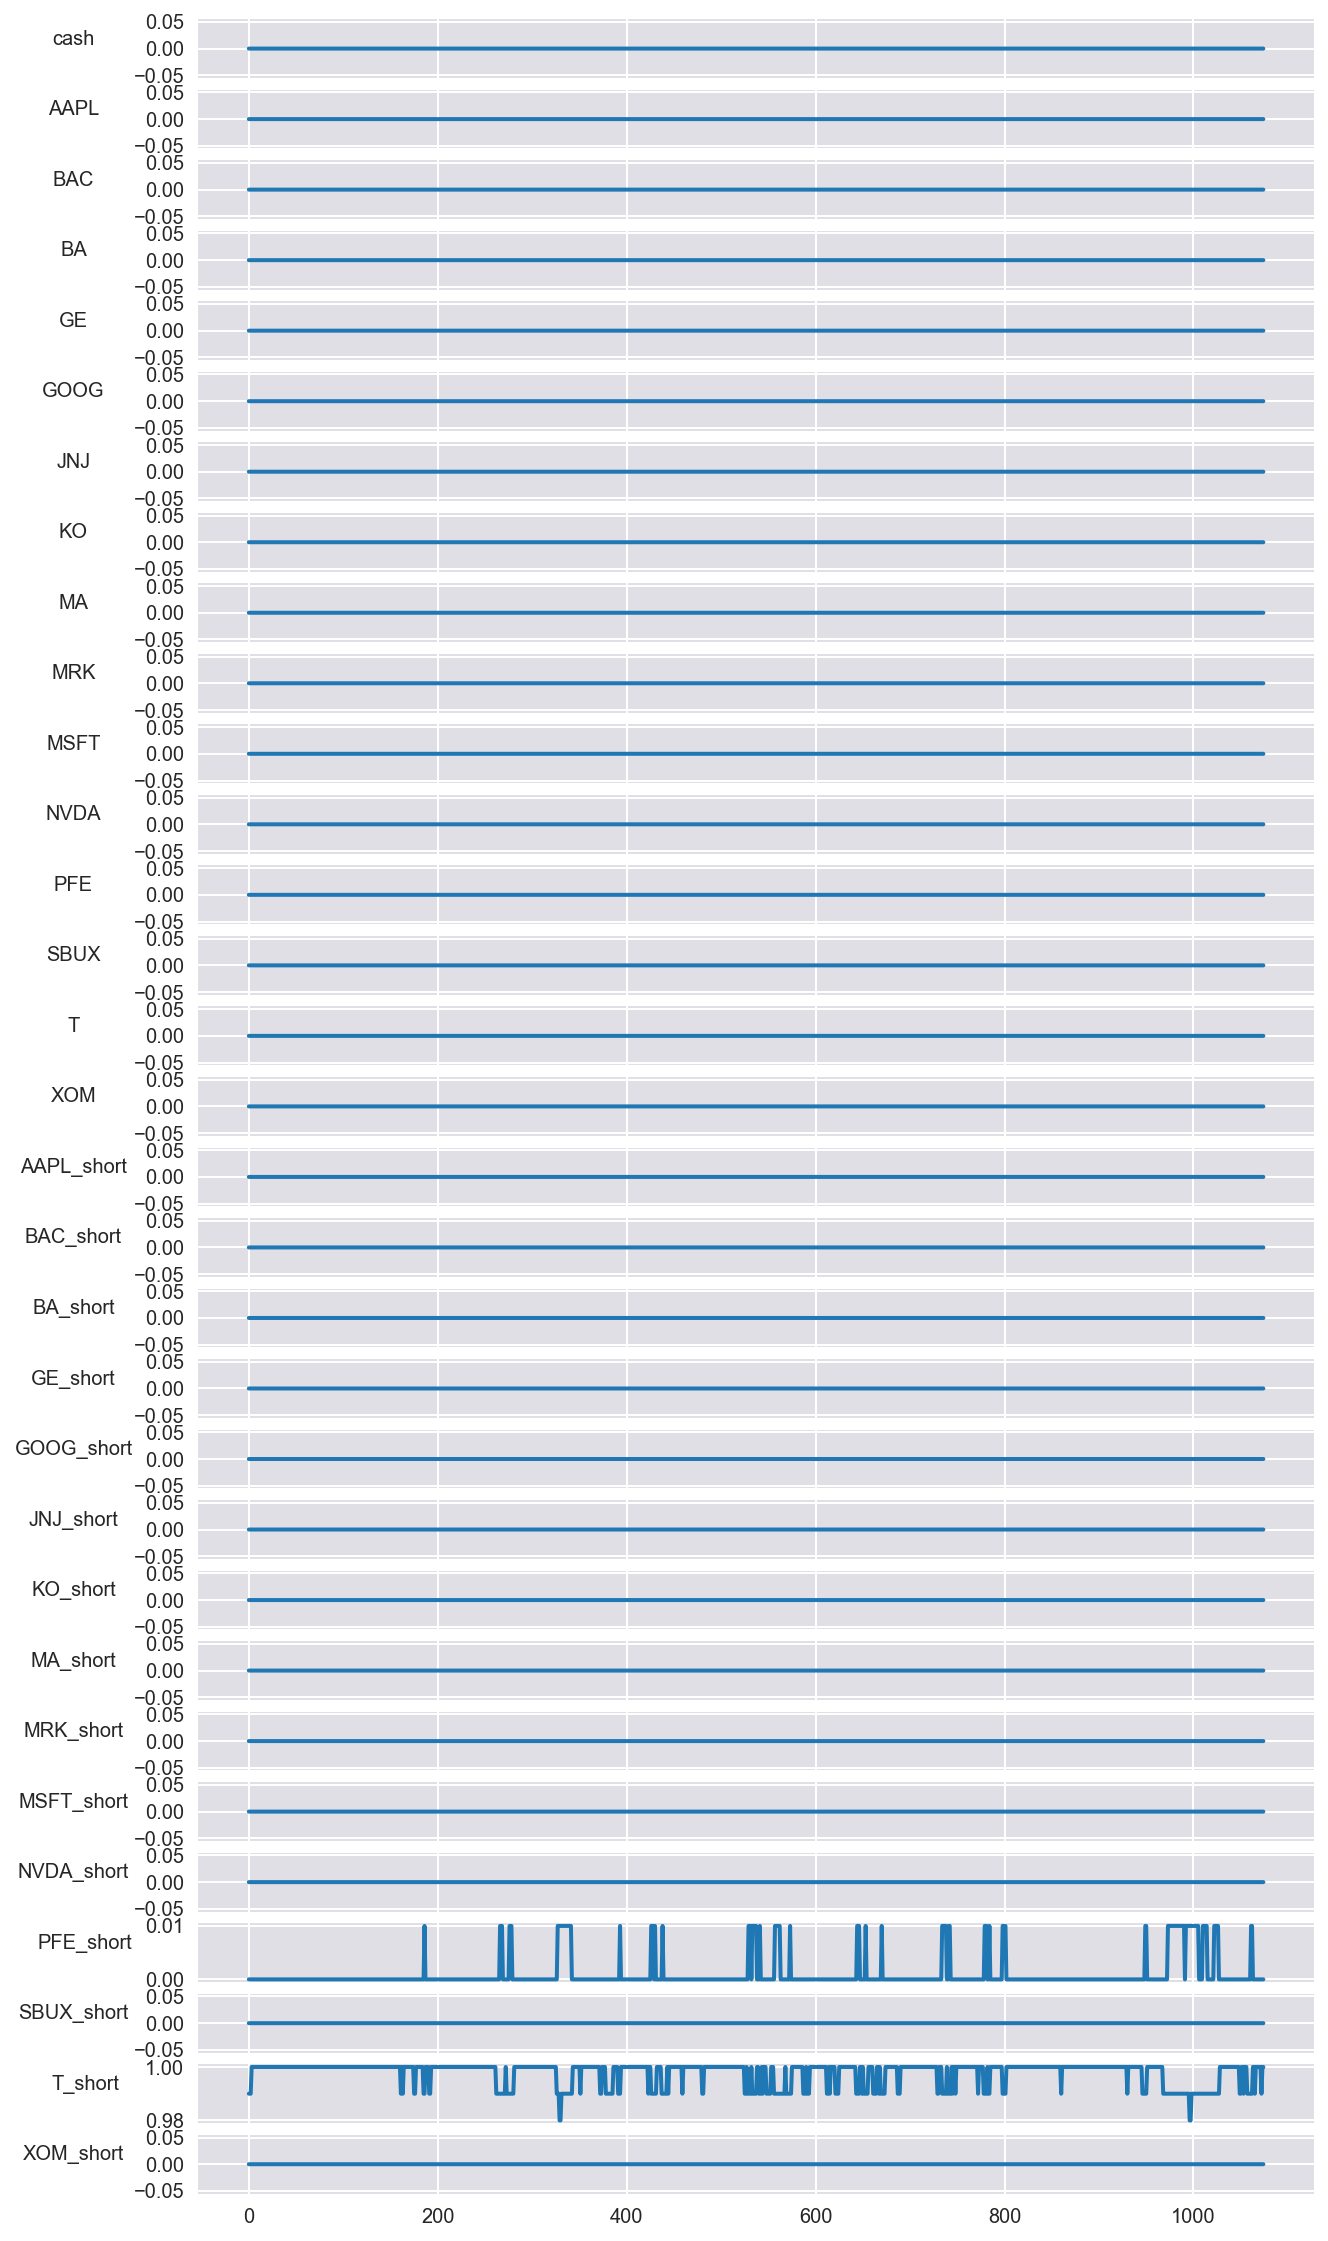

In [26]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/stock/lstm/window_30/batch_norm/Model_Mar/checkpoint.ckpt_Episode_1500/checkpoint.ckpt"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                      config_file='config/stock.json', model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=True, verbose=False)

env_Apr = PortfolioEnv(history_Apr, abbreviation, steps=history_Apr.shape[1]-200, window_length=window_length,
                   start_idx=data['Apr'].date_index.iloc[0])
test_model(env_Apr, ddpg_model)
plot_weights(env_Apr.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Apr/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


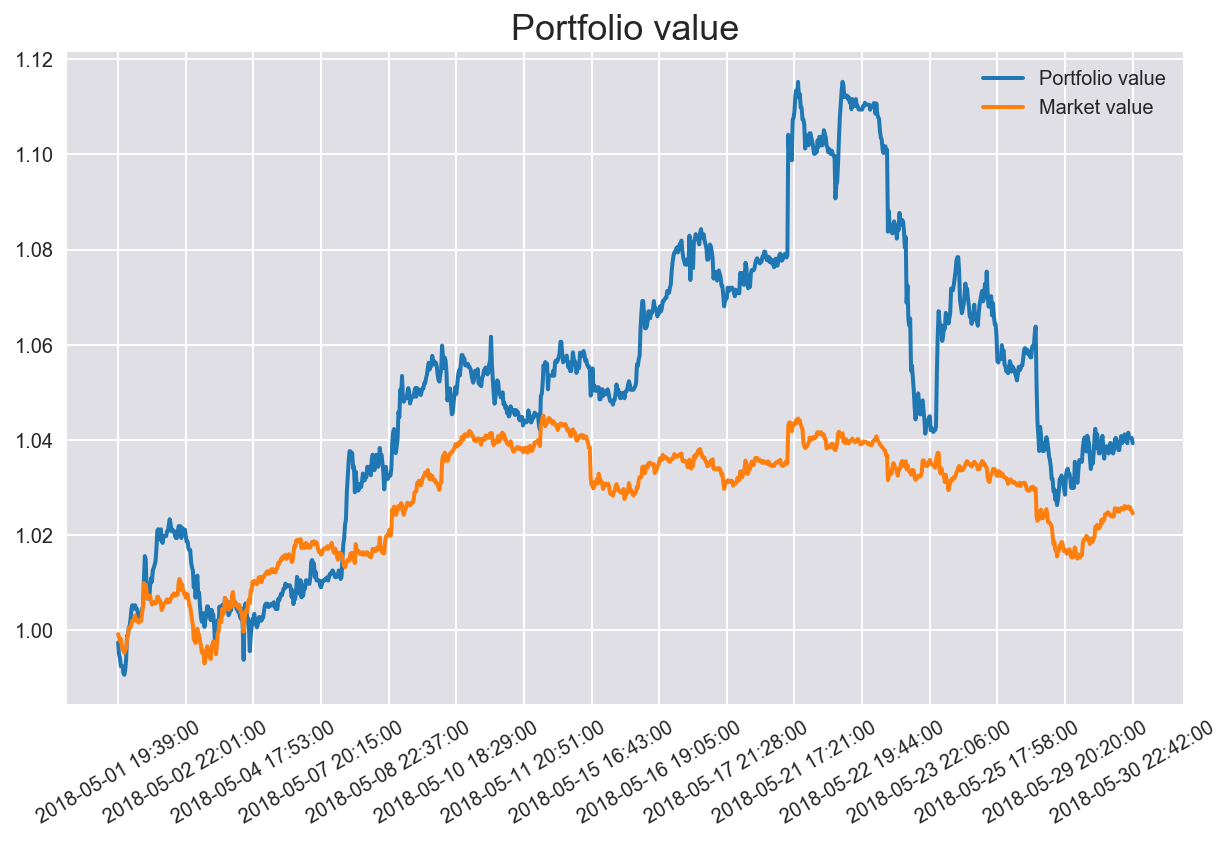

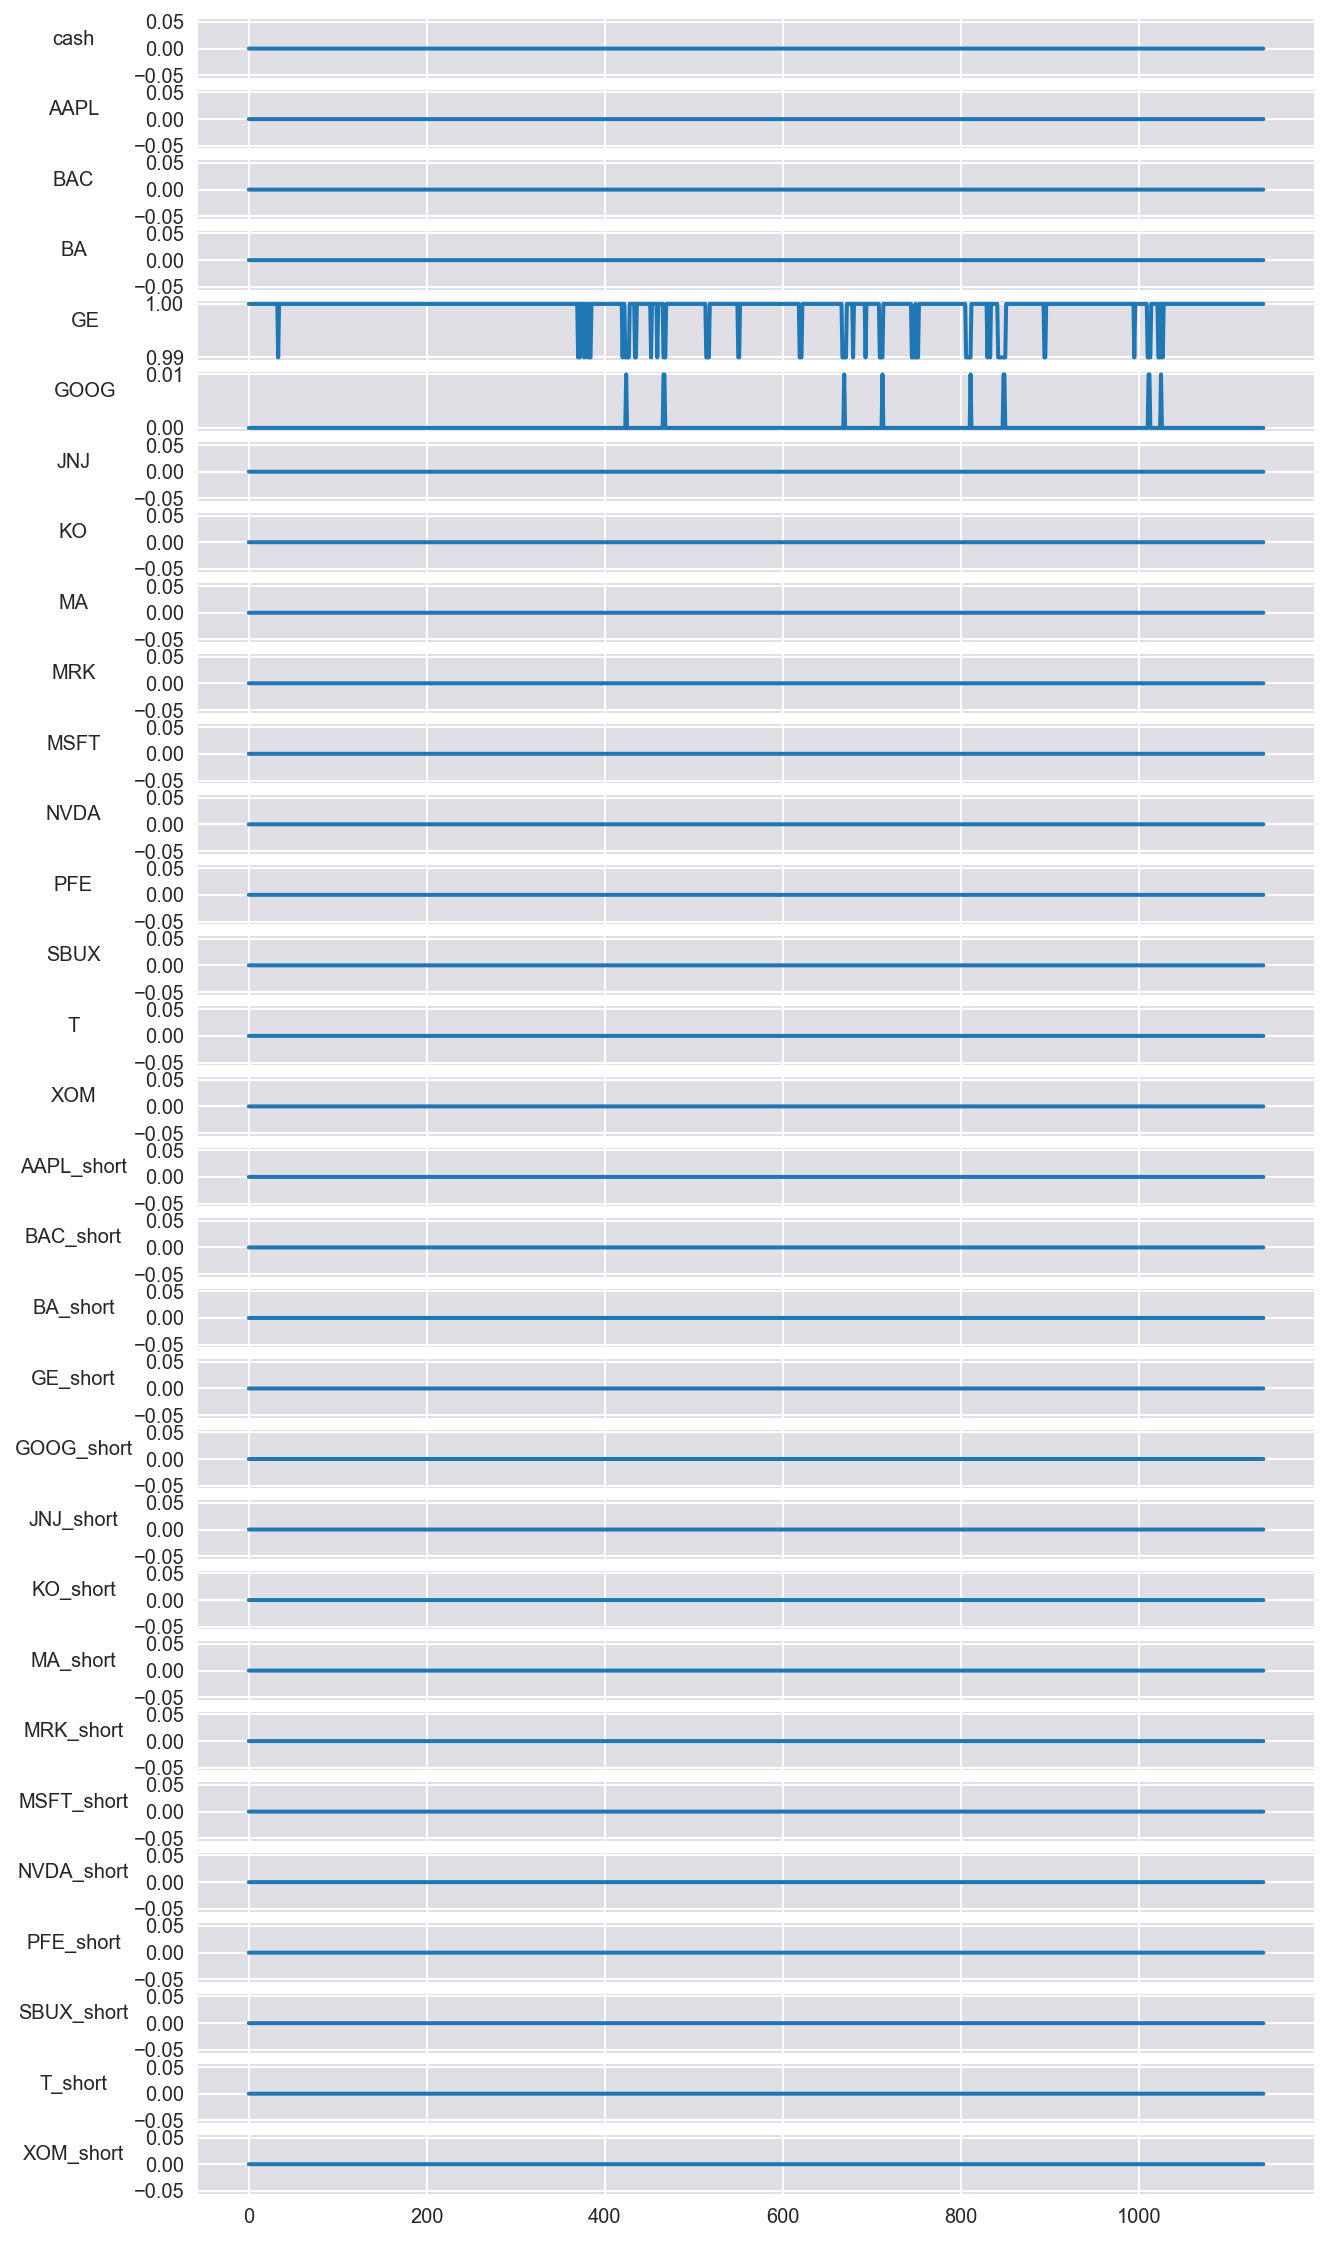

In [27]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/stock/lstm/window_30/batch_norm/Model_Apr/checkpoint.ckpt_Episode_1500/checkpoint.ckpt"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                      config_file='config/stock.json', model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=True, verbose=False)

env_May = PortfolioEnv(history_May, abbreviation, steps=history_May.shape[1]-200, window_length=window_length,
                   start_idx=data['May'].date_index.iloc[0])
test_model(env_May, ddpg_model)
plot_weights(env_May.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_May/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


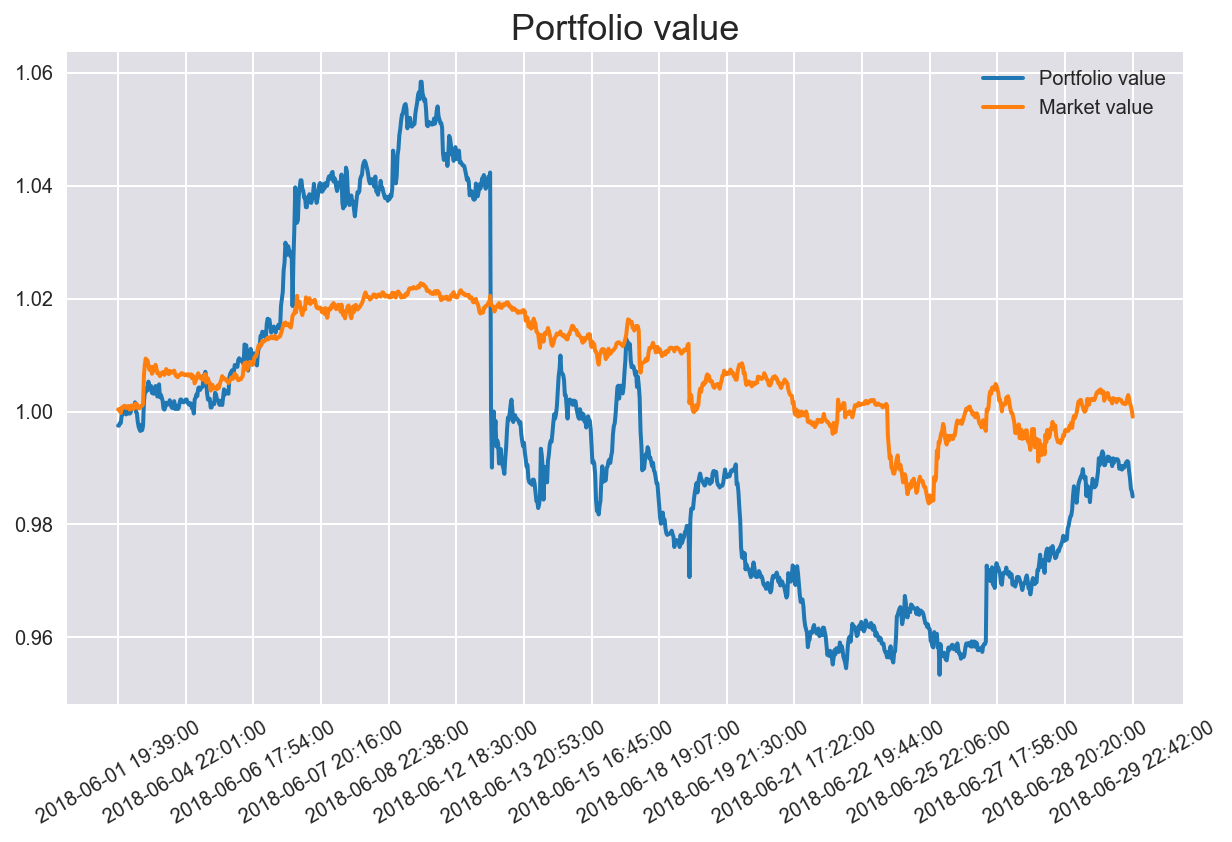

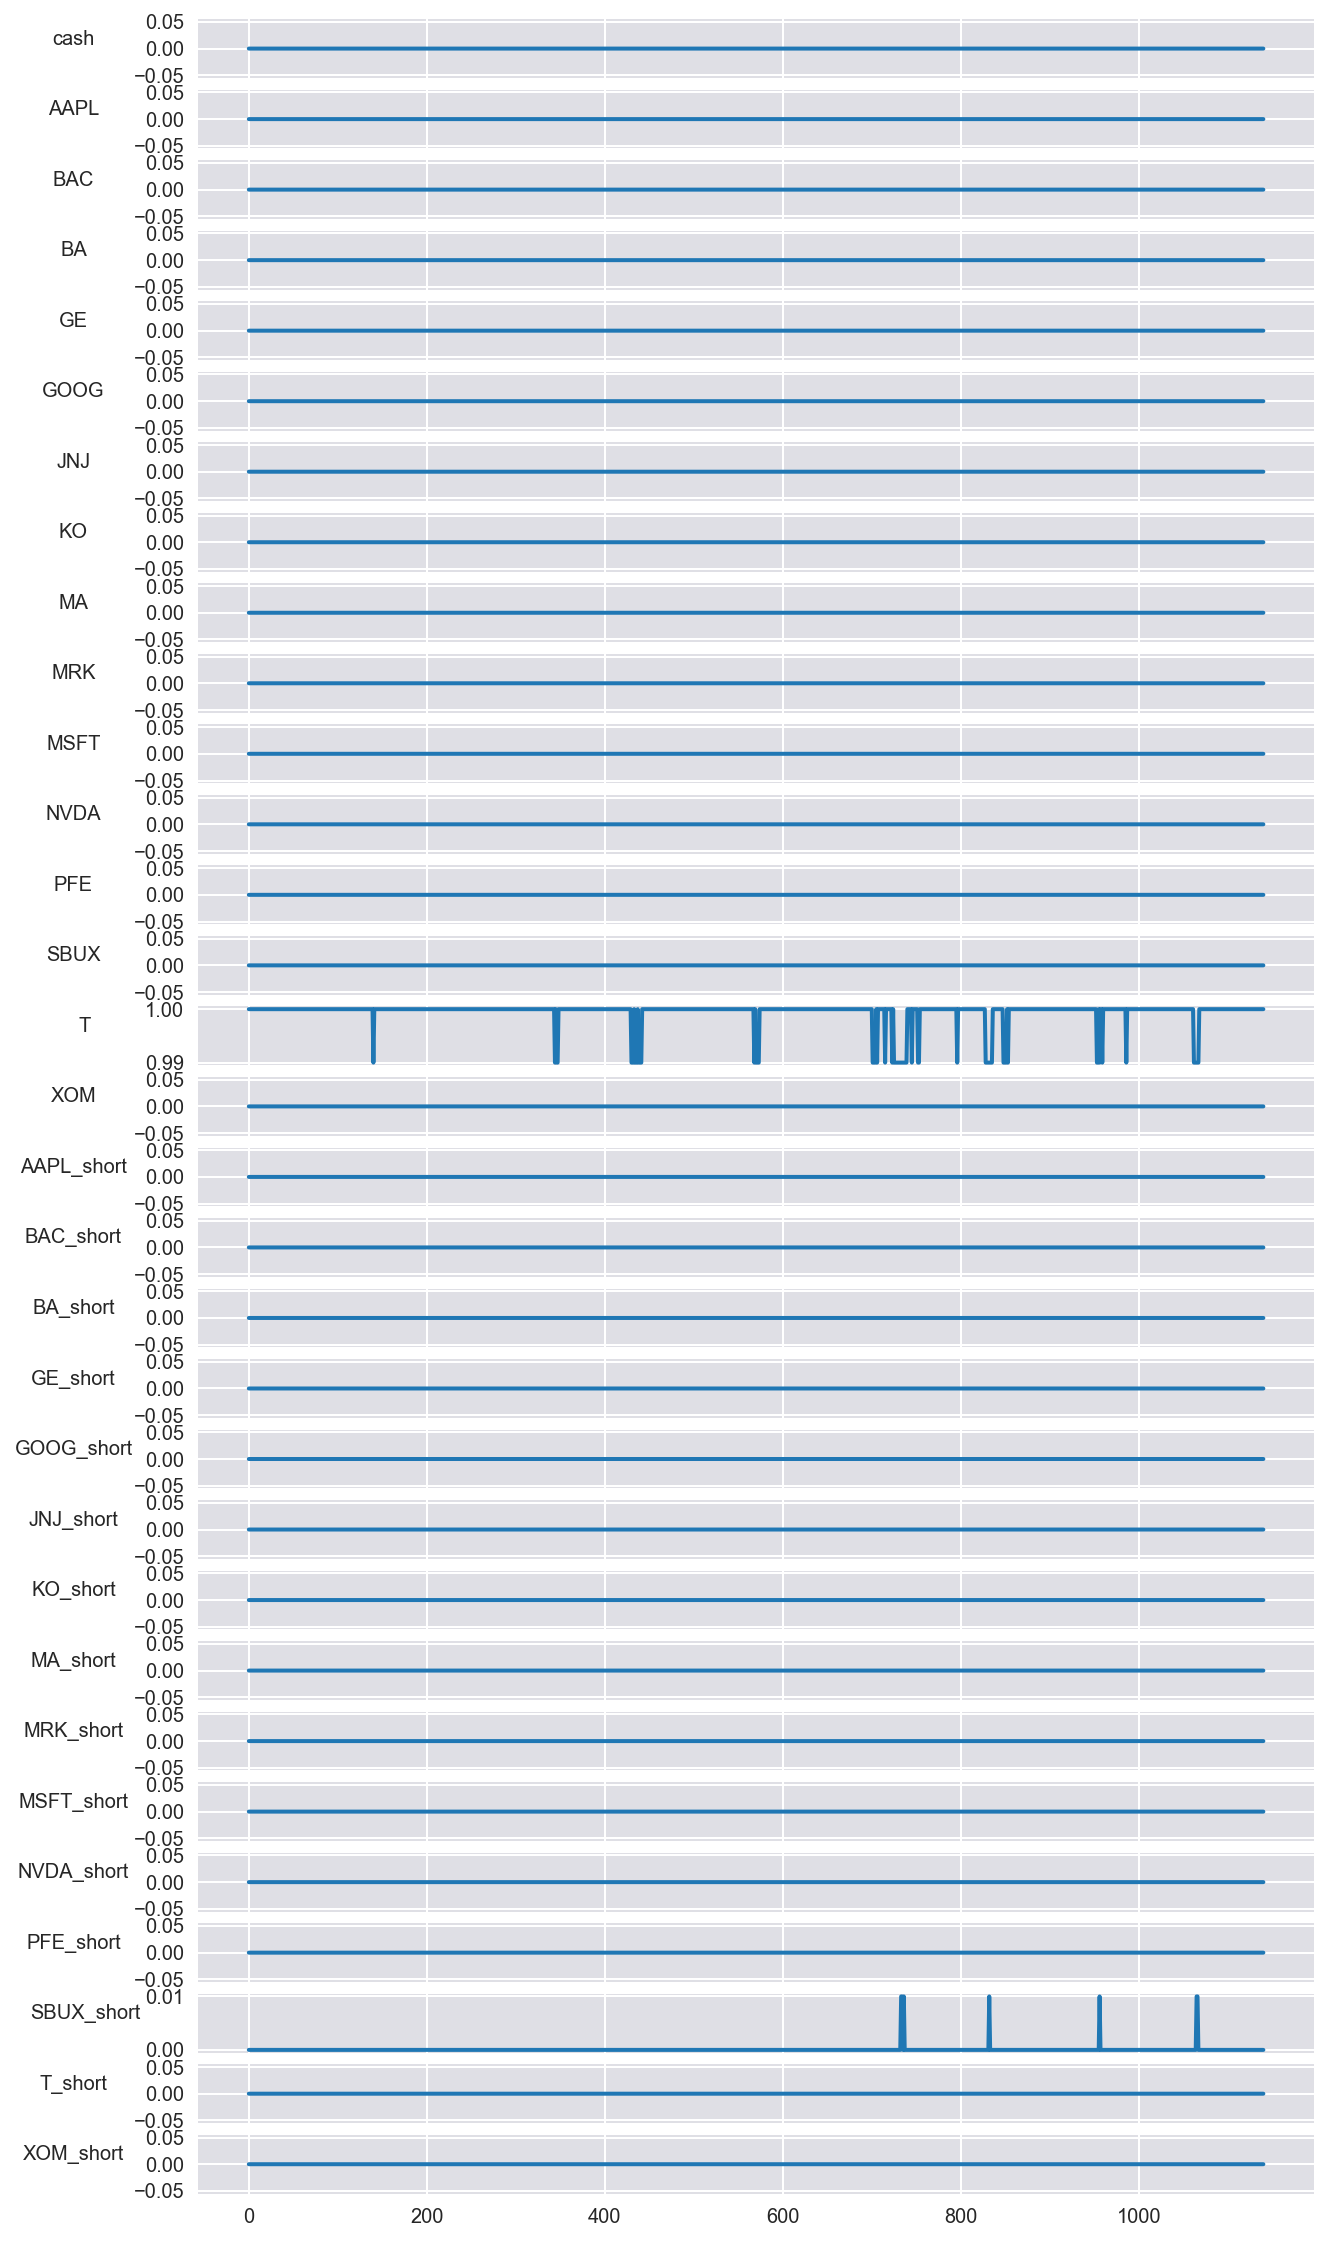

In [28]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/stock/lstm/window_30/batch_norm/Model_May/checkpoint.ckpt_Episode_1500/checkpoint.ckpt"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                      config_file='config/stock.json', model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=True, verbose=False)
    
env_Jun = PortfolioEnv(history_Jun, abbreviation, steps=history_Jun.shape[1]-200, window_length=window_length,
                   start_idx=data['Jun'].date_index.iloc[0])
test_model(env_Jun, ddpg_model)
plot_weights(env_Jun.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Jun/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


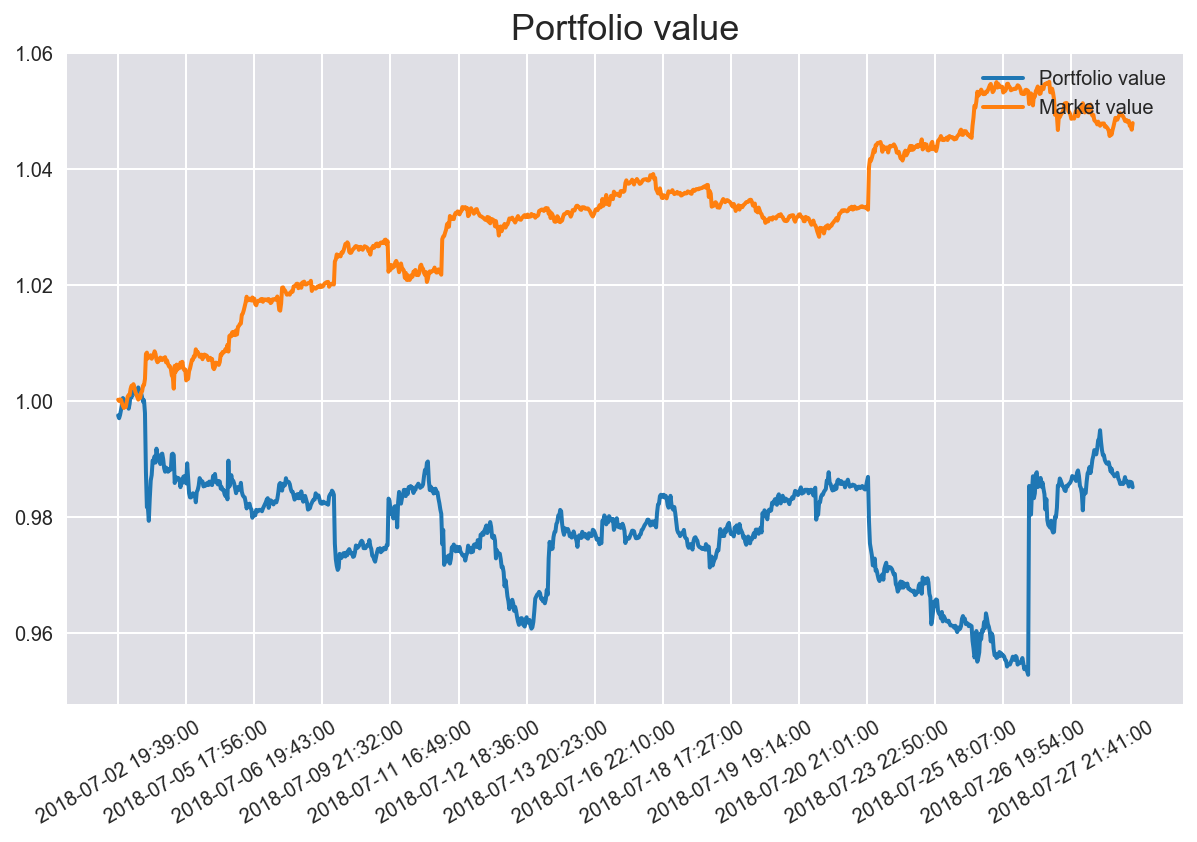

In [29]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/stock/lstm/window_30/batch_norm/Model_Jun/checkpoint.ckpt_Episode_1500/checkpoint.ckpt"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                      config_file='config/stock.json', model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=True, verbose=False)

env_Jul = PortfolioEnv(history_Jul, abbreviation, steps=history_Jul.shape[1]-200, window_length=window_length,
                   start_idx=data['Jul'].date_index.iloc[0])
test_model(env_Jul, ddpg_model)
plot_weights(env_Jul.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Jul/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


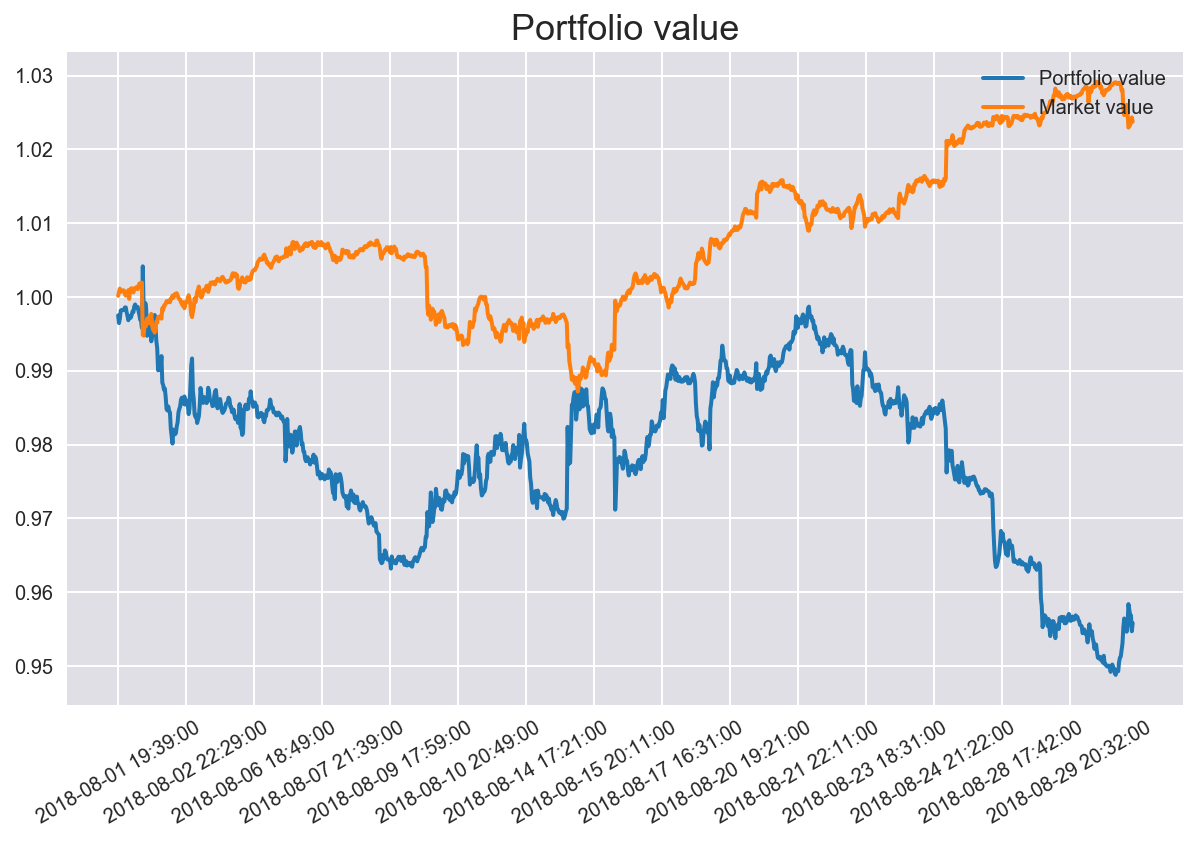

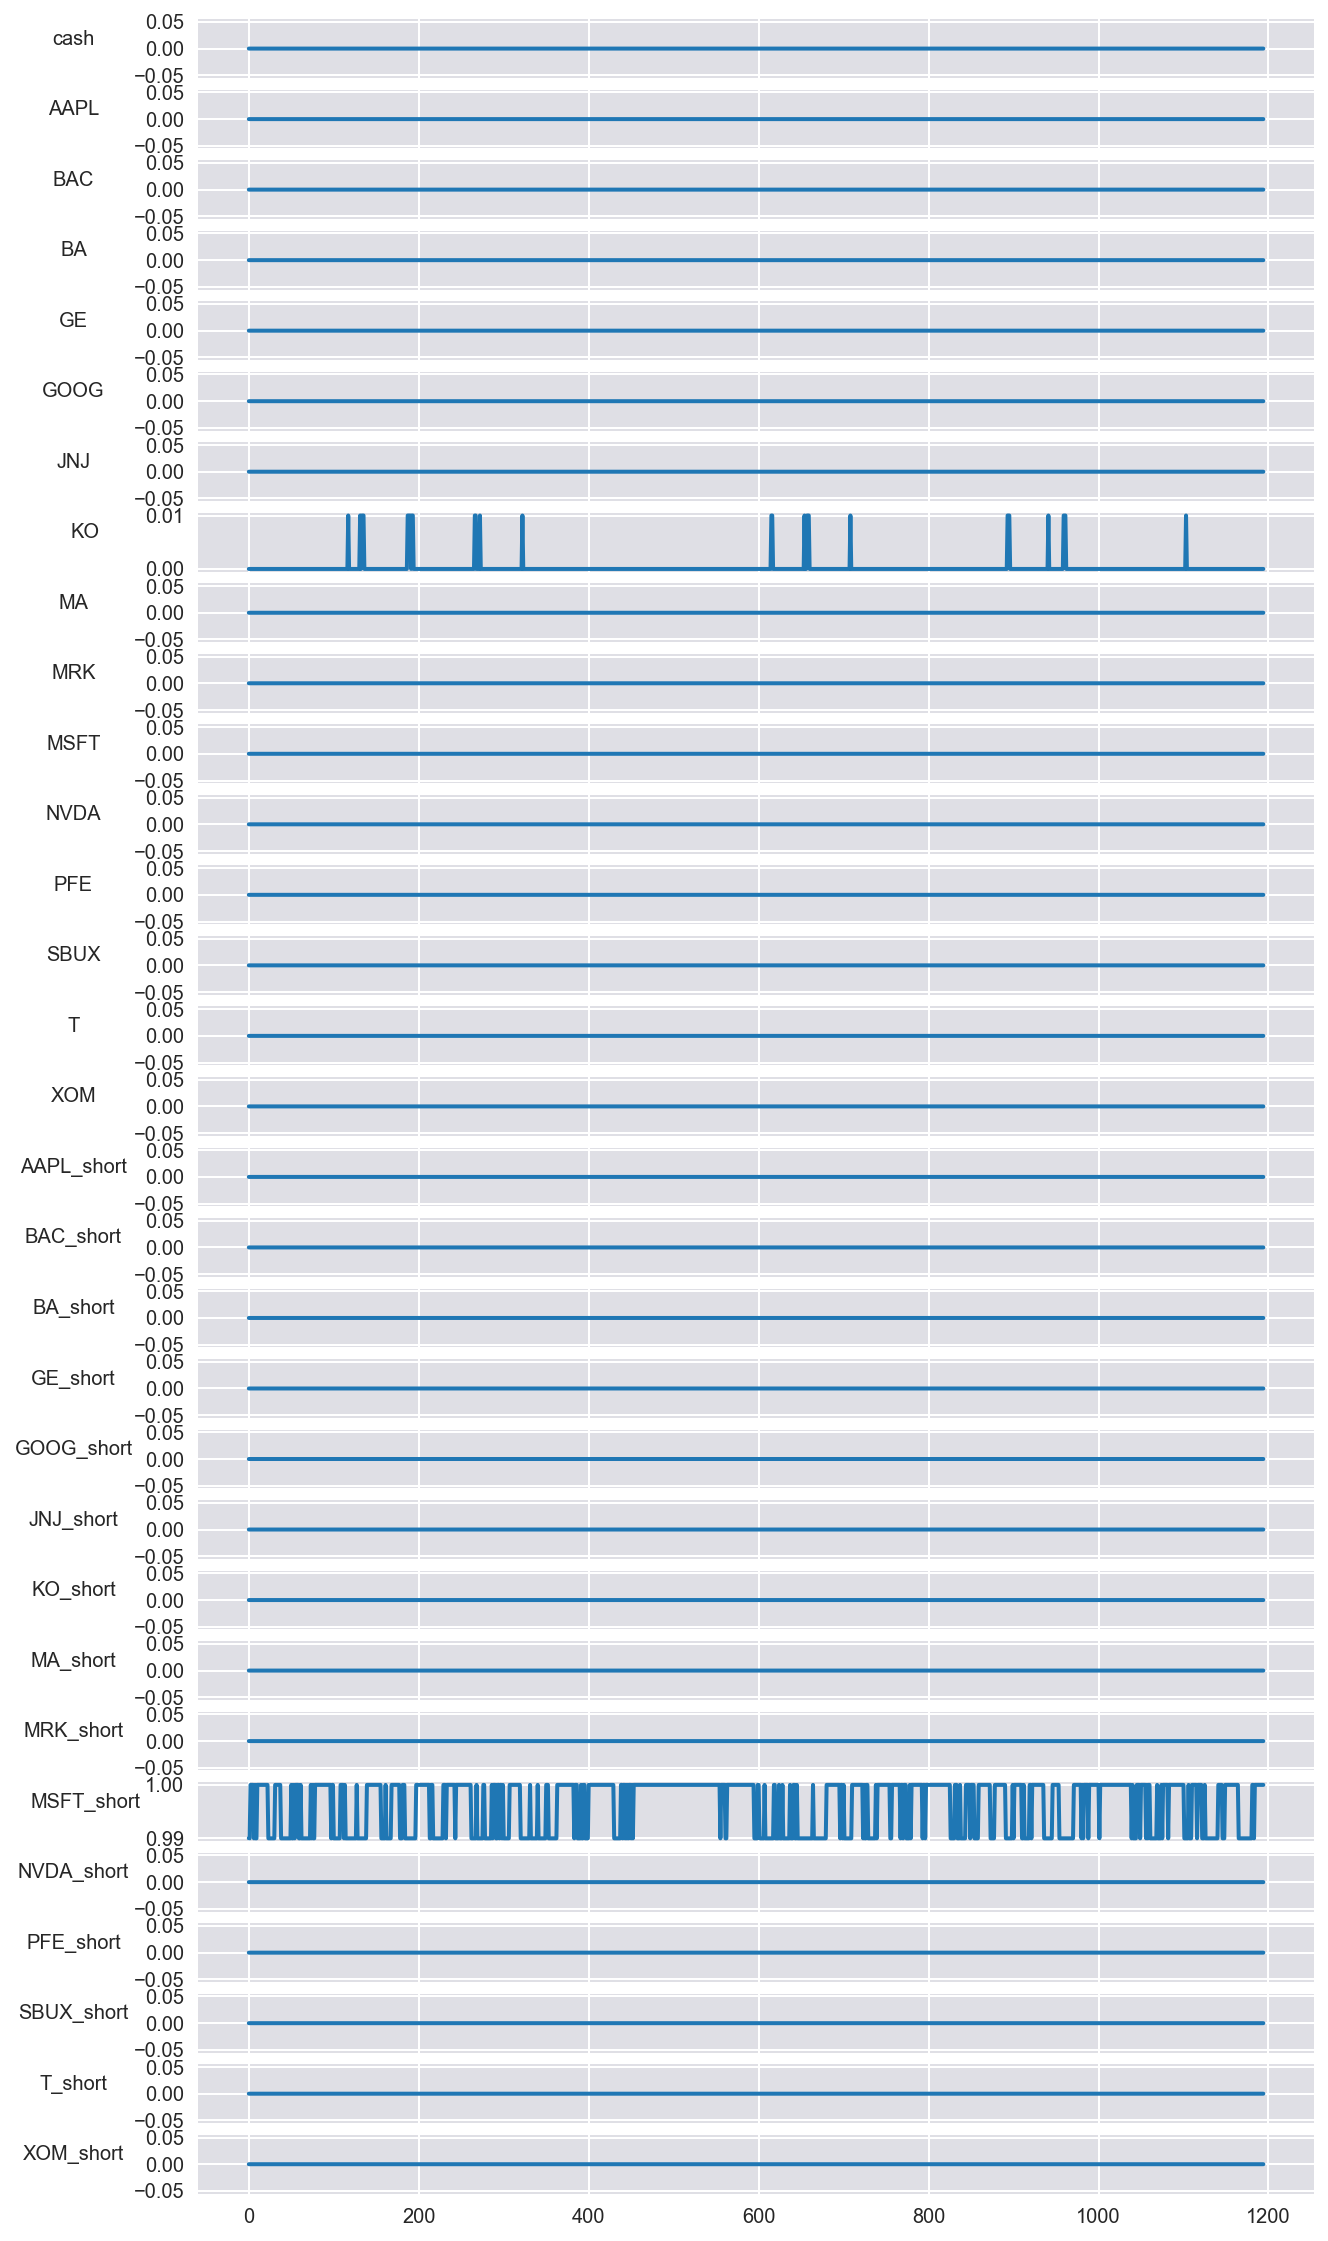

In [30]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/stock/lstm/window_30/batch_norm/Model_Jul/checkpoint.ckpt_Episode_1500/checkpoint.ckpt"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                      config_file='config/stock.json', model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=True, verbose=False)

env_Aug = PortfolioEnv(history_Aug, abbreviation, steps=history_Aug.shape[1]-200, window_length=window_length,
                   start_idx=data['Aug'].date_index.iloc[0])
test_model(env_Aug, ddpg_model)
plot_weights(env_Aug.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Aug/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


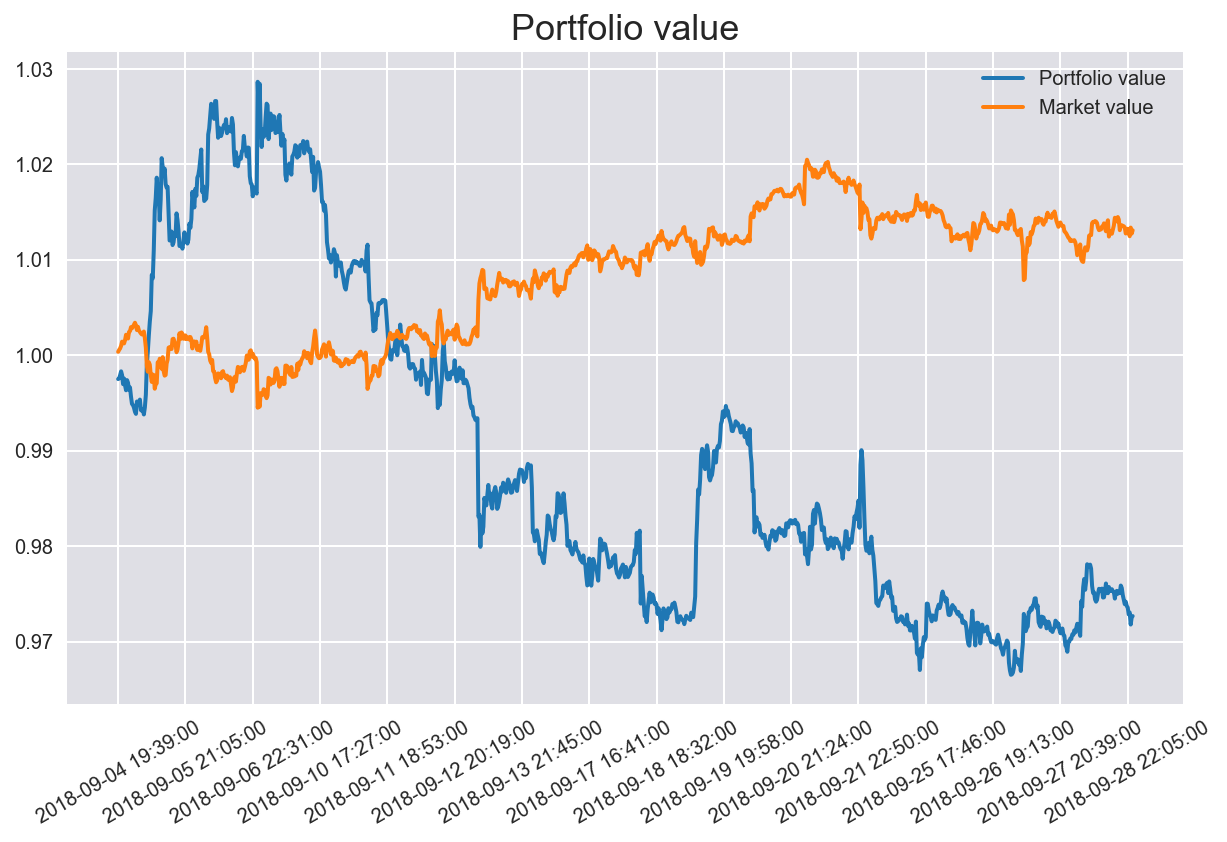

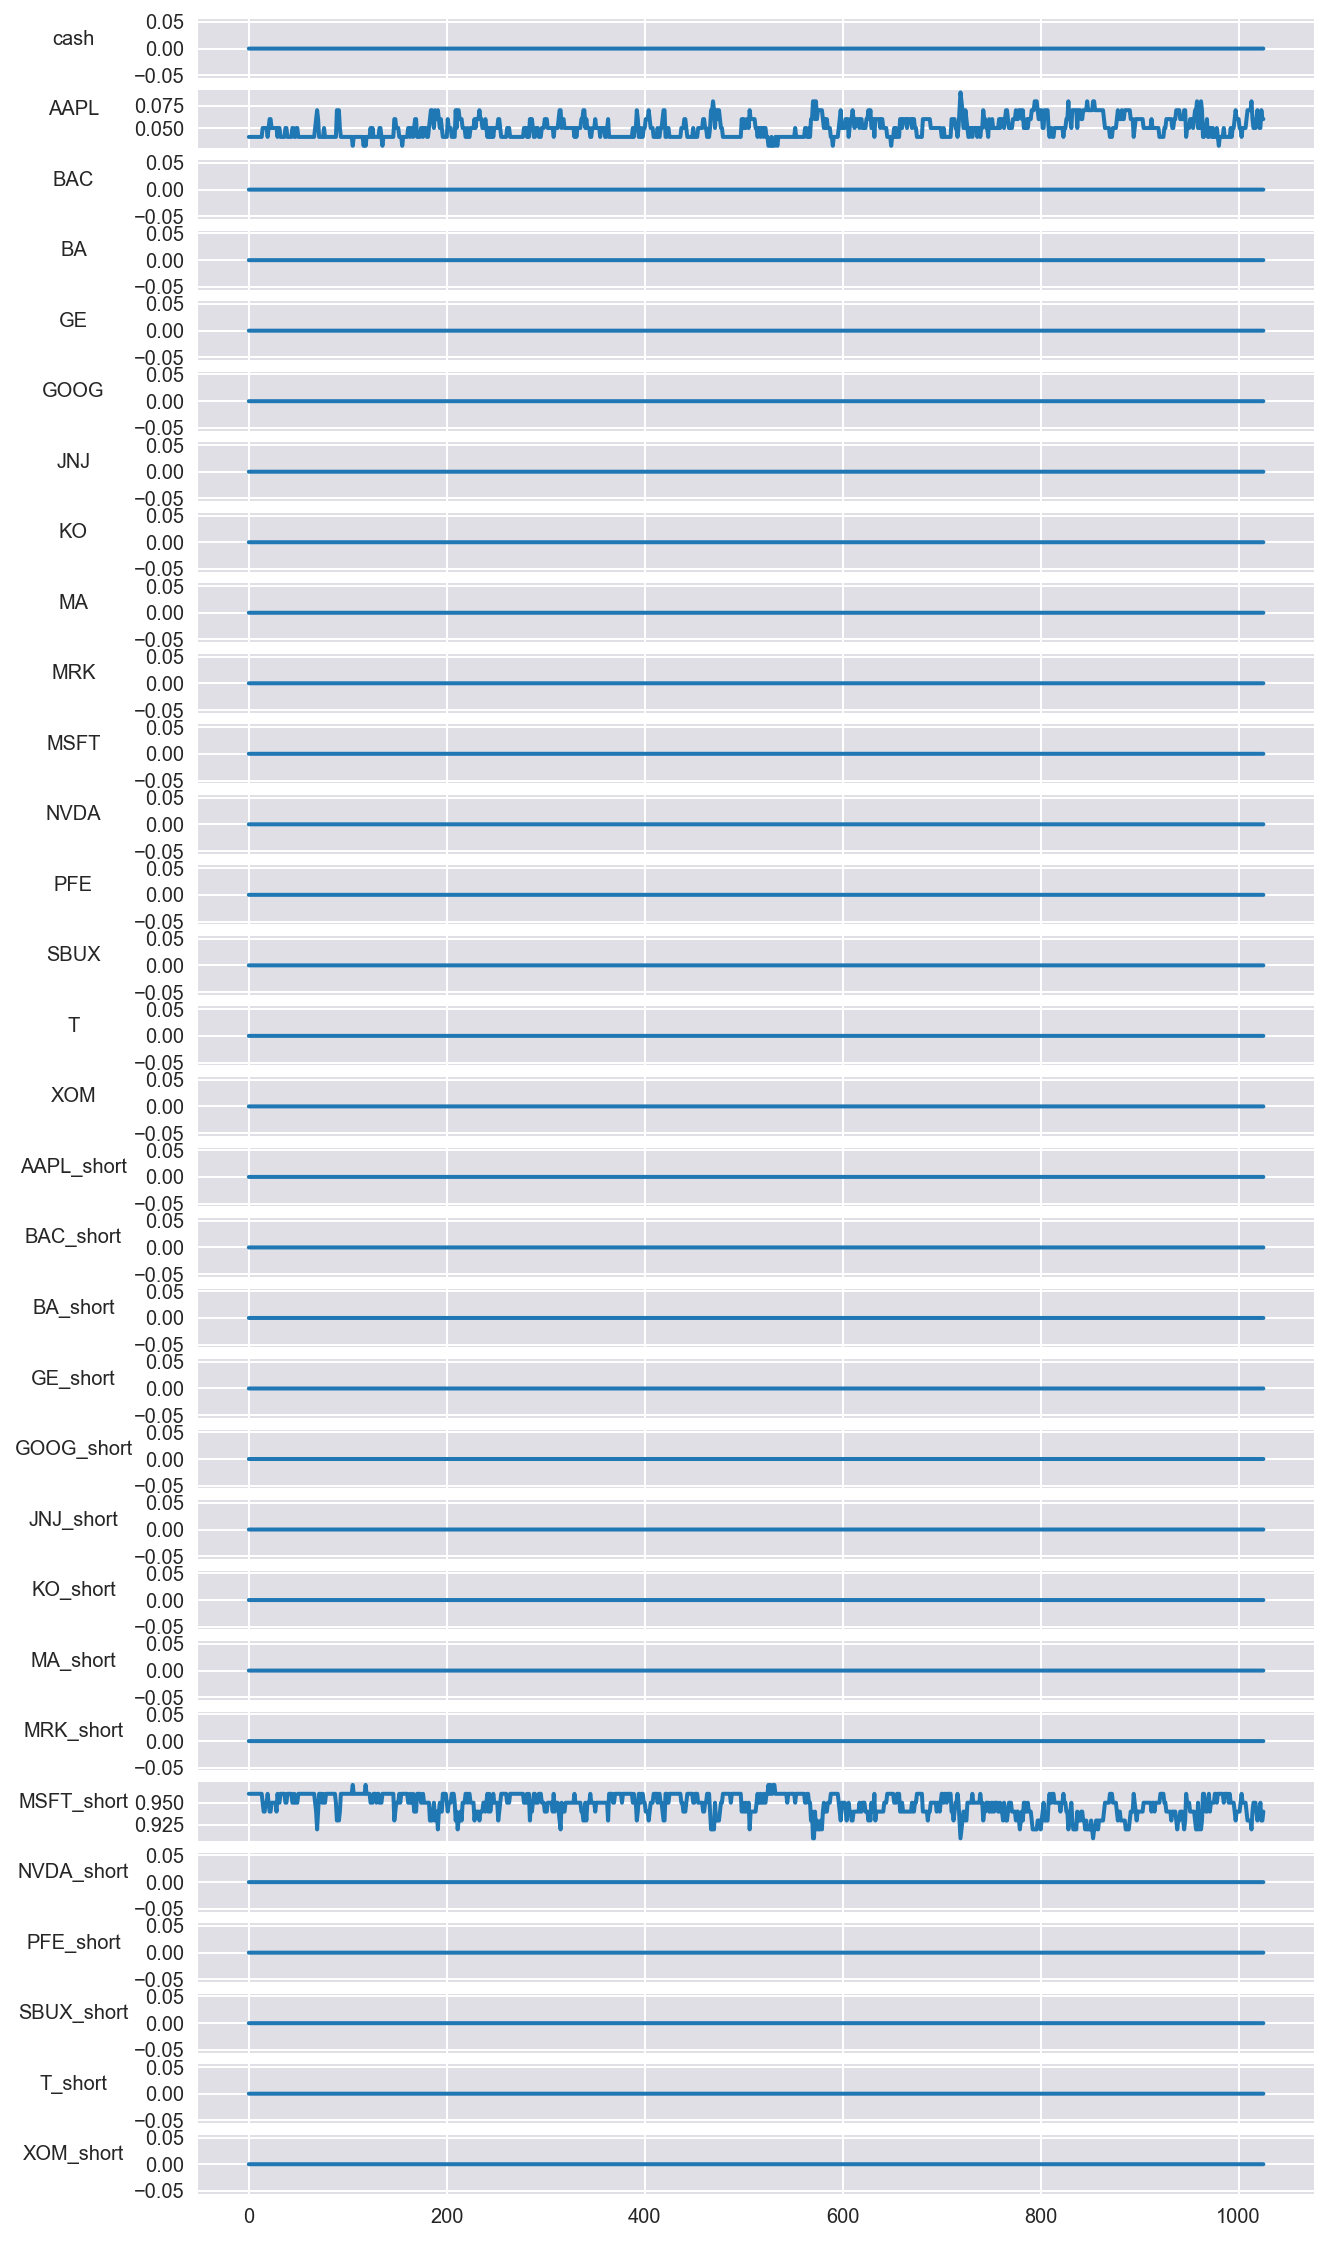

In [31]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/stock/lstm/window_30/batch_norm/Model_Aug/checkpoint.ckpt_Episode_1500/checkpoint.ckpt"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                      config_file='config/stock.json', model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=True, verbose=False)

env_Sep = PortfolioEnv(history_Sep, abbreviation, steps=history_Sep.shape[1]-200, window_length=window_length,
                   start_idx=data['Sep'].date_index.iloc[0])
test_model(env_Sep, ddpg_model)
plot_weights(env_Sep.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Sep/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


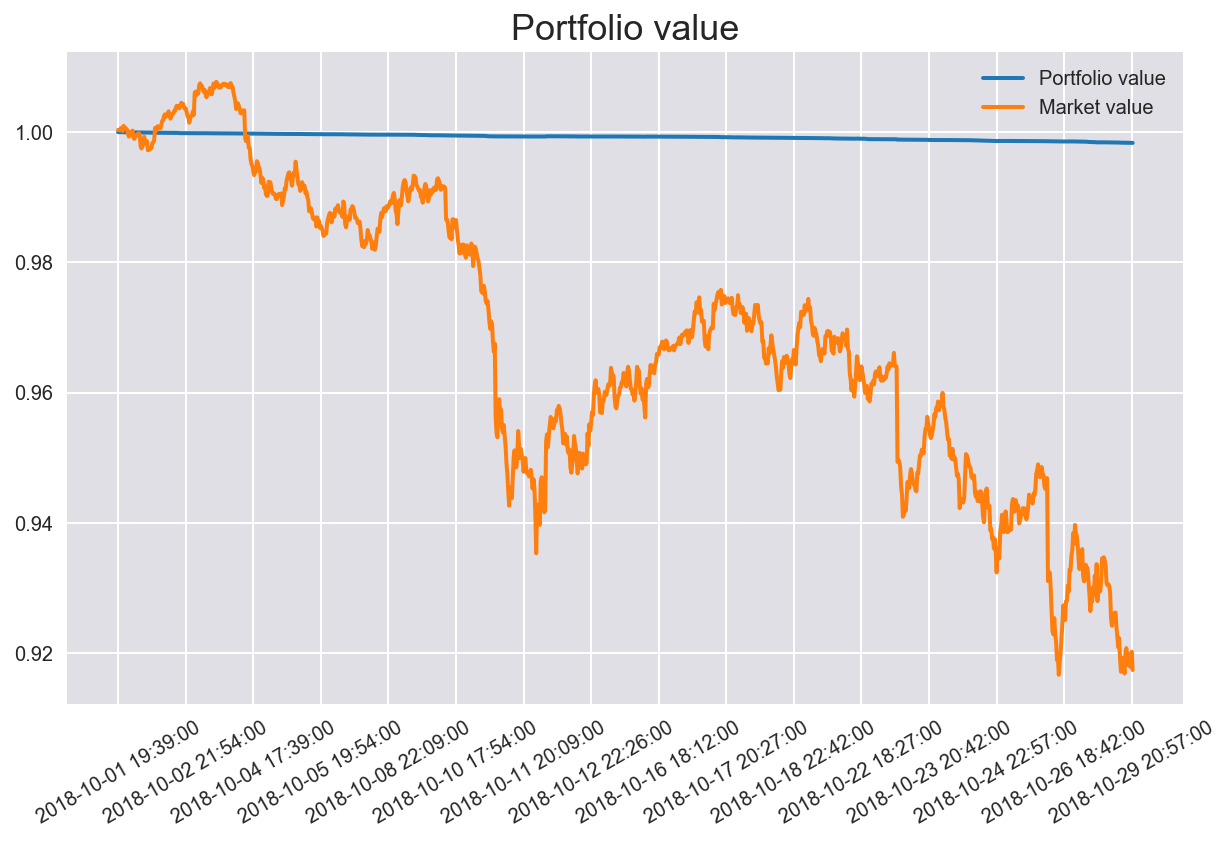

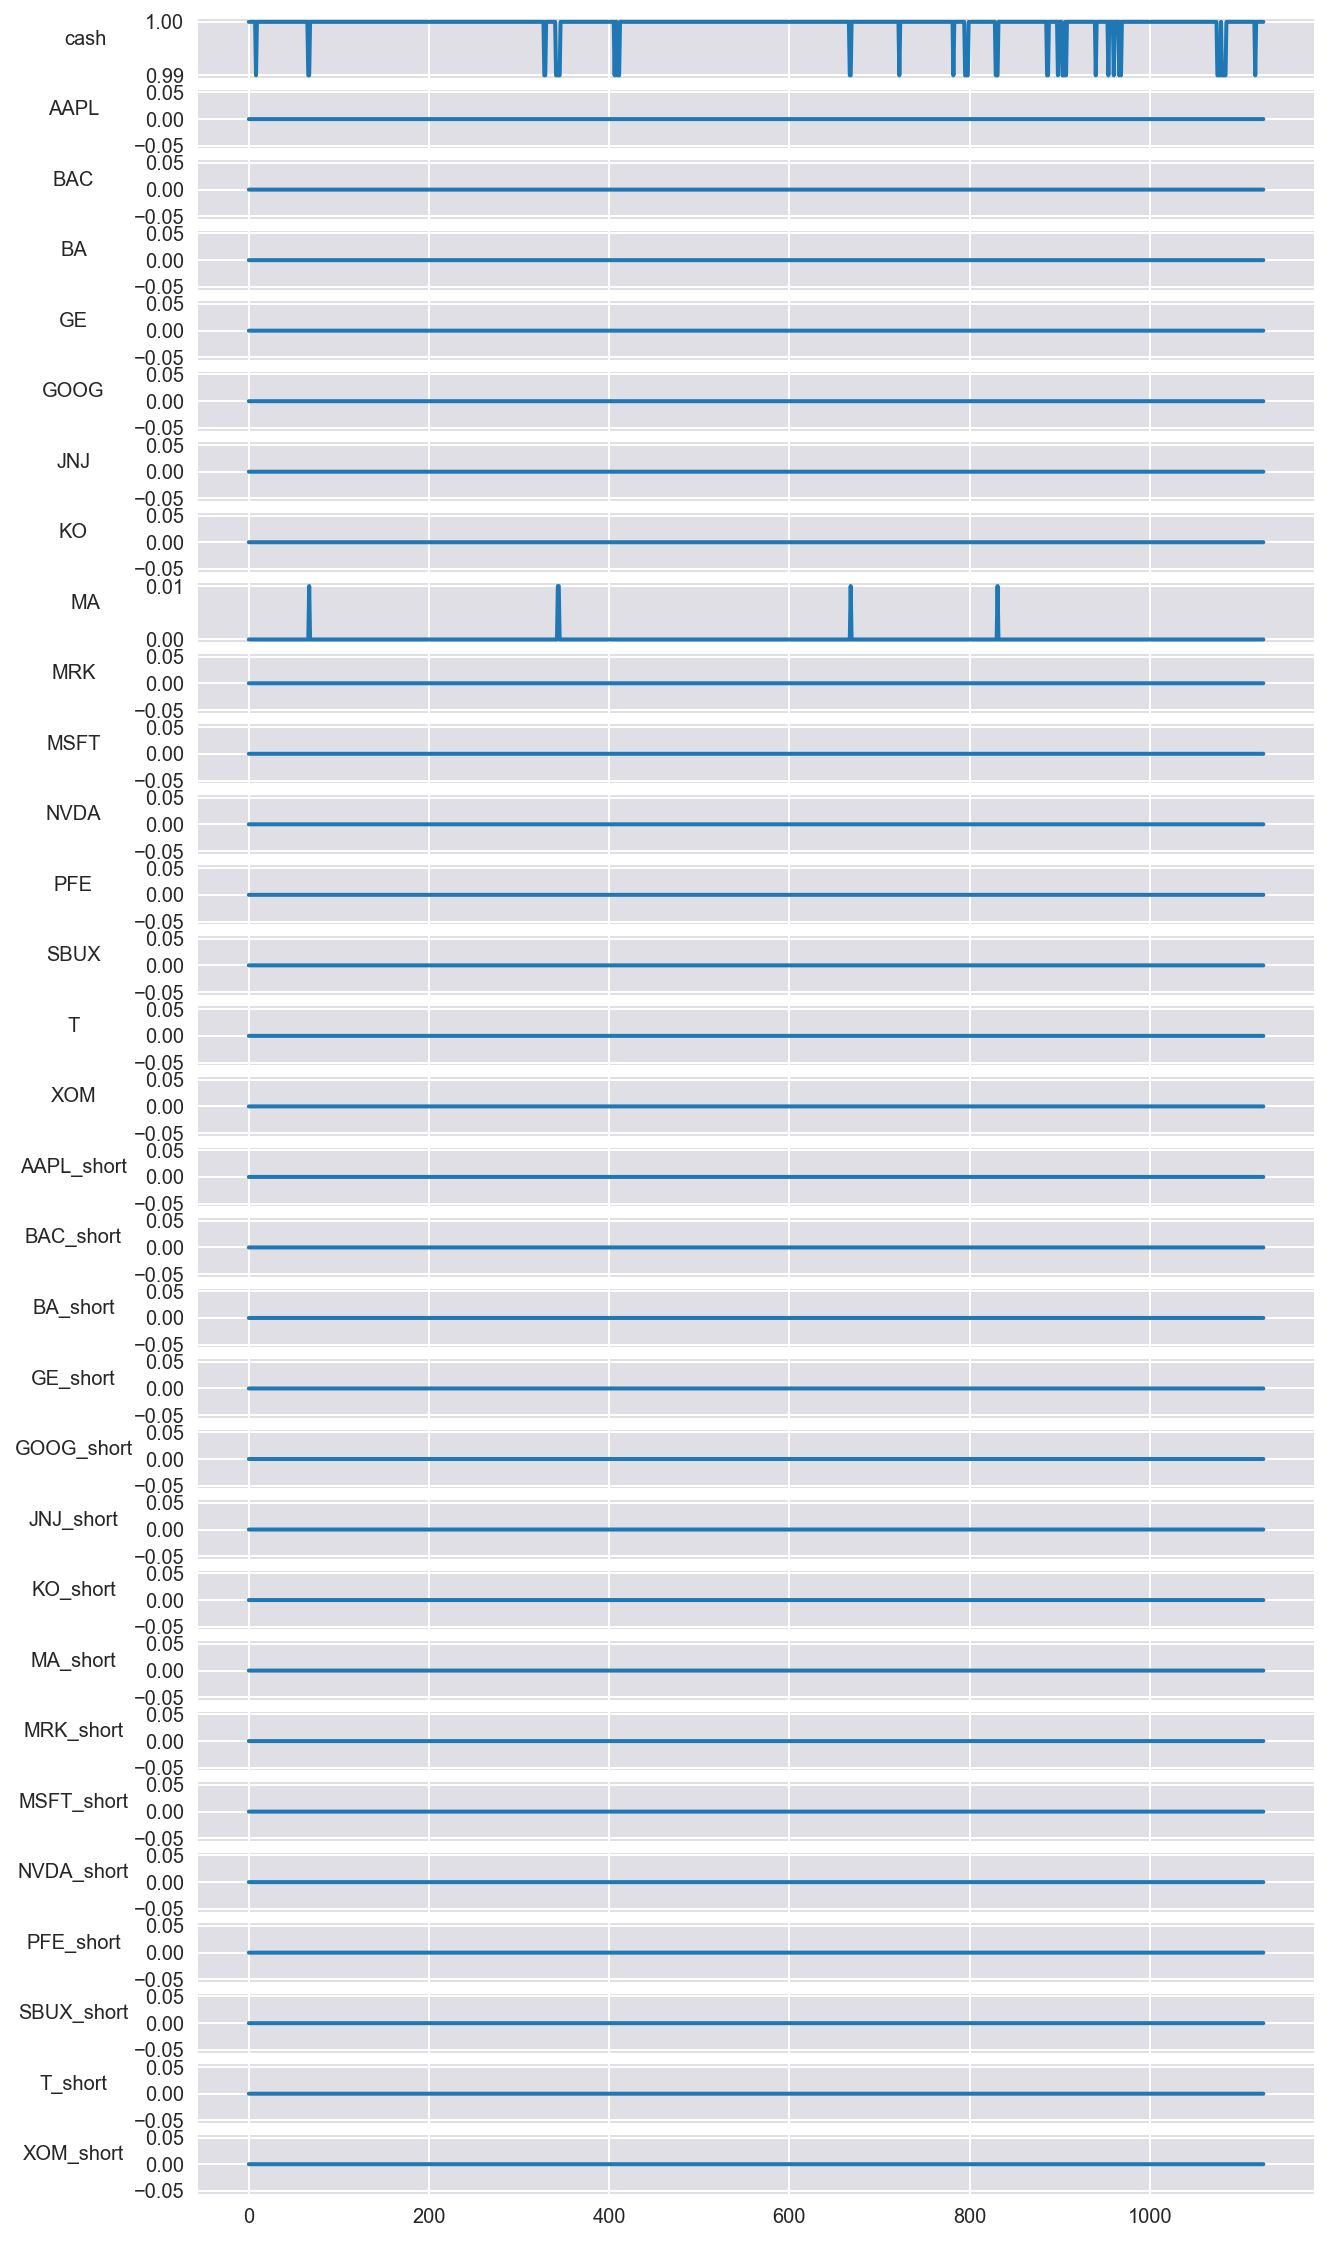

In [32]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/stock/lstm/window_30/batch_norm/Model_Sep/checkpoint.ckpt_Episode_1500/checkpoint.ckpt"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                      config_file='config/stock.json', model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=True, verbose=False)

env_Oct = PortfolioEnv(history_Oct, abbreviation, steps=history_Oct.shape[1]-200, window_length=window_length,
                   start_idx=data['Oct'].date_index.iloc[0])
test_model(env_Oct, ddpg_model)
plot_weights(env_Oct.infos)

Final P/L from 2018/02/01 to 2018/10/29

In [33]:
1*env_Feb.infos[-1]['portfolio_value']*env_Mar.infos[-1]['portfolio_value']*env_Apr.infos[-1]['portfolio_value']*env_May.infos[-1]['portfolio_value']*env_Jun.infos[-1]['portfolio_value']*env_Jul.infos[-1]['portfolio_value']*env_Aug.infos[-1]['portfolio_value']*env_Sep.infos[-1]['portfolio_value']*env_Oct.infos[-1]['portfolio_value']

1.146375231650955

Benchmark - buy every stock(no short position) uniformly and hold.

In [34]:
1*env_Feb.infos[-1]['market_value']*env_Mar.infos[-1]['market_value']*env_Apr.infos[-1]['market_value']*env_May.infos[-1]['market_value']*env_Jun.infos[-1]['market_value']*env_Jul.infos[-1]['market_value']*env_Aug.infos[-1]['market_value']*env_Sep.infos[-1]['market_value']*env_Oct.infos[-1]['market_value']

1.0563464635195277

Benchmark - buy stock with best performance last month

In [35]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']

In [36]:
performance = dict()
for i in month:
    performance[i]=dict()

In [37]:
for j in month:
    for i in abbreviation['symbols']:
        value_change = data[j].loc[:, i+'_close'].iloc[-1]/data[j].loc[:, i+'_open'].iloc[0]
        performance[j][i] = value_change

In [38]:
performance

{'Jan': {'AAPL': 0.9809613350569985,
  'BAC': 1.0711409395973155,
  'BA': 1.1435526404760297,
  'GE': 0.9075654152445962,
  'GOOG': 1.1104635913185719,
  'JNJ': 1.0216394382344511,
  'KO': 1.0336527989544761,
  'MA': 1.1005921052631578,
  'MRK': 1.0740937223695846,
  'MSFT': 1.0773875181422352,
  'NVDA': 1.240461719188927,
  'PFE': 1.0402472527472528,
  'SBUX': 0.9887698686938492,
  'T': 0.9613118114271074,
  'XOM': 1.0366261035552375},
 'Feb': {'AAPL': 1.0695417789757413,
  'BAC': 1.0147243107769424,
  'BA': 1.0790539541759054,
  'GE': 0.909746161078032,
  'GOOG': 0.962603973327834,
  'JNJ': 0.9241829148548183,
  'KO': 0.9207753898019385,
  'MA': 1.0532261438689818,
  'MRK': 0.9018768521567336,
  'MSFT': 1.017782088587132,
  'NVDA': 1.0131714344515332,
  'PFE': 0.9716134143121206,
  'SBUX': 0.9899528219465316,
  'T': 0.9834754797441363,
  'XOM': 0.8943613348676639},
 'Mar': {'AAPL': 0.9411929431531784,
  'BAC': 0.9254284390921723,
  'BA': 0.8986408724721872,
  'GE': 0.9290144727773949

In [39]:
import operator
best_of_month = []
for i in month[:-1]:
    best_of_month.append(max(performance[i].items(), key=operator.itemgetter(1))[0])

In [40]:
best_of_month

['NVDA', 'BA', 'SBUX', 'MRK', 'NVDA', 'MRK', 'BAC', 'NVDA', 'BA']

In [41]:
month_invest = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']

In [42]:
outcome = []
for i in range(9):
    outcome.append(performance[month_invest[i]][best_of_month[i]])

In [43]:
outcome

[1.0131714344515332,
 0.8986408724721872,
 1.0146036161335188,
 1.0015254237288136,
 0.9323994648618872,
 1.0678747940691926,
 0.9932713873758411,
 1.0034982508745627,
 0.9068782786994382]

In [44]:
np.cumprod(outcome)[-1]

0.8326900679223337